                                           VELLORE INSTITUTE OF TECHNOLOGY
                                              MBS 6099 - MASTER THESIS
                                              
<b>PROJECT TITLE - PREDICTIVE MAINTENANCE FOR AIRCRAFT ENGINES</b>

### Goal 

* The goal is to predict the remaining useful component of life. The remaining useful life estimates are in the units of time (cycles/hours/mileage). 
* We have used Linear and non - linear models to predict the Time To Failure of a machine.
                                             
                                           

## Dataset Details:


The dataset is taken from the Prognostics Data Repository of NASA (National Aeronautics and Space Administration). the dataset description as follows:


1. Engine unit number
2. Time elapsed, measured in cycles
3. Three distinct operational configurations
4. 21 recorded sensor measurements

Notably, specific details concerning the types of sensors, such as pressure sensors, temperature sensors, vibration sensors, etc., have not been provided. Incorporating such sensor-specific knowledge could potentially yield deeper insights into engine degradation through domain expertise.


# Importing Libraries and dependencies

In [10]:
import keras
import keras.backend as K
from keras.layers import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Loading the Dataset

 * read training data - It is the aircraft engine run-to-failure data. 
 * read test data - It is the aircraft engine operating data without failure events recorded.
 * read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.

In [11]:
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
test_df = pd.read_csv('PM_test.txt', sep=" ", header=None)
truth_df = pd.read_csv('PM_truth.txt', sep=" ", header=None)

In [12]:
# Drop missing data columns(redundant)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [13]:
# Sorting and indicating columns
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [14]:
train_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95  23.3442  
3  38.88  23.3739  
4  38.90  23.4044  

[5 rows x 26 columns]

In [15]:
test_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1    0.0023    0.0003     100.0  518.67  643.02  1585.29  1398.21   
1   1      2   -0.0027   -0.0003     100.0  518.67  641.71  1588.45  1395.42   
2   1      3    0.0003    0.0001     100.0  518.67  642.46  1586.94  1401.34   
3   1      4    0.0042    0.0000     100.0  518.67  642.44  1584.12  1406.42   
4   1      5    0.0014    0.0000     100.0  518.67  642.51  1587.19  1401.92   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.72  2388.03  8125.55  8.4052  0.03  392  2388  100.0   
1  14.62  ...  522.16  2388.06  8139.62  8.3803  0.03  393  2388  100.0   
2  14.62  ...  521.97  2388.03  8130.10  8.4441  0.03  393  2388  100.0   
3  14.62  ...  521.38  2388.05  8132.90  8.3917  0.03  391  2388  100.0   
4  14.62  ...  522.15  2388.03  8129.54  8.4031  0.03  390  2388  100.0   

     s20      s21  
0  38.86  23.3735  
1  39.02  23.3916  
2  39.08  23.4166  
3  39.00  23.3737  
4  38.99  23.4130  

[5 rows x 26 columns]

In [16]:
truth_df
truth_df.columns = ['time-to-failure']
truth_df.head()

time-to-failure
0              112
1               98
2               69
3               82
4               91

In [17]:
train_df.shape

(20631, 26)

In [18]:
test_df.shape

(13096, 26)

In [19]:
truth_df.shape

(100, 1)

## Exploratory data Analysis on the datasets


#### Overview on how the data is collected:

The dataset contains the Time-series measurements of various components of the Aircraft engine. There are Three operational settings and 21 sensor measurements for each engine. collected data contains sensor noise as well.  

In [20]:
# describing the Dataset information 
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  float64
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20  s16       20631 non-null  fl

In [21]:
# description details of Train dataset 
train_df.describe().transpose()

count         mean           std        min        25%        50%  \
id        20631.0    51.506568  2.922763e+01     1.0000    26.0000    52.0000   
cycle     20631.0   108.807862  6.888099e+01     1.0000    52.0000   104.0000   
setting1  20631.0    -0.000009  2.187313e-03    -0.0087    -0.0015     0.0000   
setting2  20631.0     0.000002  2.930621e-04    -0.0006    -0.0002     0.0000   
setting3  20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s1        20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s2        20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s3        20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s4        20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s5        20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s6        20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s7        20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s8        20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s9        20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s10       20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s11       20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s12       20631.0   521.413470  7.375534e-01   518.6900   520.9600   521.4800   
s13       20631.0  2388.096152  7.191892e-02  2387.8800  2388.0400  2388.0900   
s14       20631.0  8143.752722  1.907618e+01  8099.9400  8133.2450  8140.5400   
s15       20631.0     8.442146  3.750504e-02     8.3249     8.4149     8.4389   
s16       20631.0     0.030000  1.556432e-14     0.0300     0.0300     0.0300   
s17       20631.0   393.210654  1.548763e+00   388.0000   392.0000   393.0000   
s18       20631.0  2388.000000  0.000000e+00  2388.0000  2388.0000  2388.0000   
s19       20631.0   100.000000  0.000000e+00   100.0000   100.0000   100.0000   
s20       20631.0    38.816271  1.807464e-01    38.1400    38.7000    38.8300   
s21       20631.0    23.289705  1.082509e-01    22.8942    23.2218    23.2979   

                75%        max  
id          77.0000   100.0000  
cycle      156.0000   362.0000  
setting1     0.0015     0.0087  
setting2     0.0003     0.0006  
setting3   100.0000   100.0000  
s1         518.6700   518.6700  
s2         643.0000   644.5300  
s3        1594.3800  1616.9100  
s4        1414.5550  1441.4900  
s5          14.6200    14.6200  
s6          21.6100    21.6100  
s7         554.0100   556.0600  
s8        2388.1400  2388.5600  
s9        9069.4200  9244.5900  
s10          1.3000     1.3000  
s11         47.7000    48.5300  
s12        521.9500   523.3800  
s13       2388.1400  2388.5600  
s14       8148.3100  8293.7200  
s15          8.4656     8.5848  
s16          0.0300     0.0300  
s17        394.0000   400.0000  
s18       2388.0000  2388.0000  
s19        100.0000   100.0000  
s20         38.9500    39.4300  
s21         23.3668    23.6184



## Checking for missing values 

In [22]:
# Checking for the missing values
train_df.isnull().sum()

id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64

From the above analysis, we could see there is no null values and all the features are numeric.

In [23]:
test_df.isnull().sum()

id          0
cycle       0
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
dtype: int64


### Histograms of the dataset variables

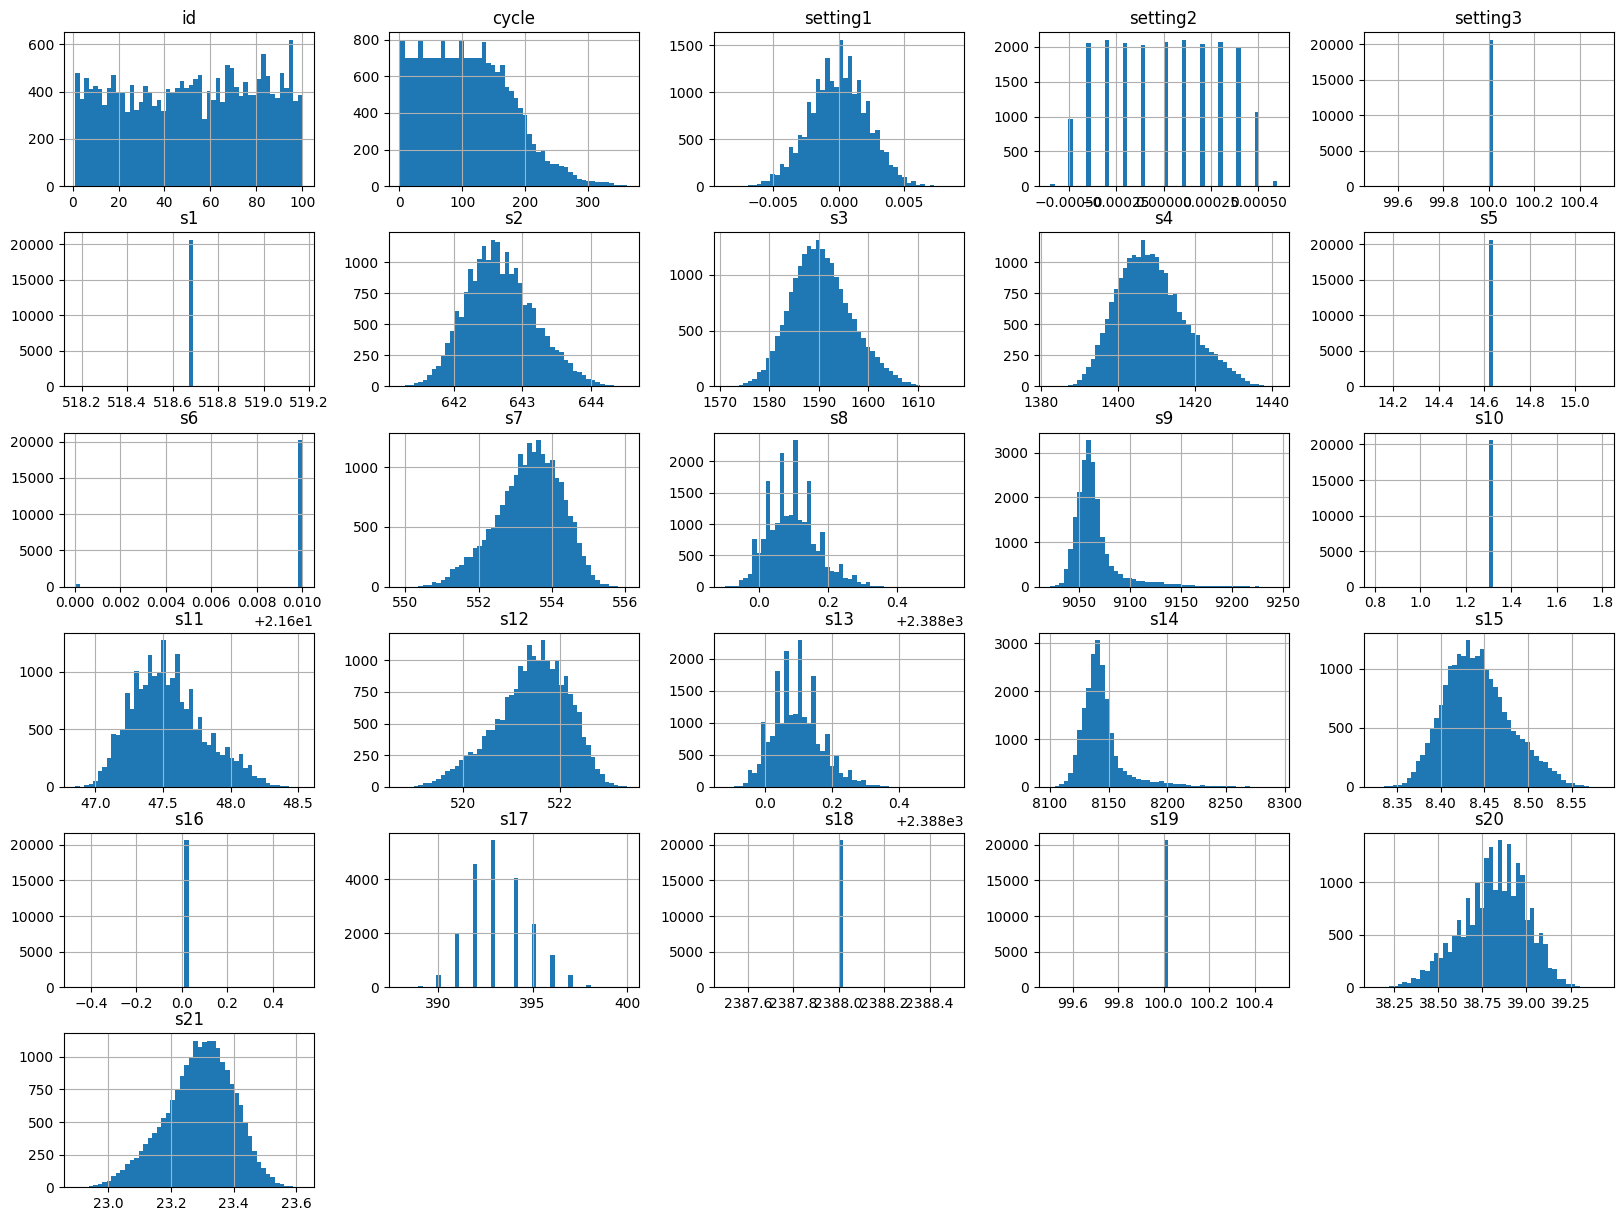

In [24]:
# Histogram plots of the varibles in the train data.
%matplotlib inline
train_df.hist(bins=50, figsize=(20,15))
plt.show()

From the above figures, we could see that all the attributes are numeric and continuous variables. Only setting2 and S17 are discrete variables in the data. 

We can also note that some of the sensors and settings do not change with time. they are constant and hence they can be removed from the analysis. 

Variables that are constant with time - [ op_setting3, S1, S10, S16, S18, S19, S5, S6]. These attributes/Variables can be removed from the analysis while modeling. 


#### Mean and standard deviation of all features in terms of barplots

<Axes: title={'center': 'Mean of all columns'}>

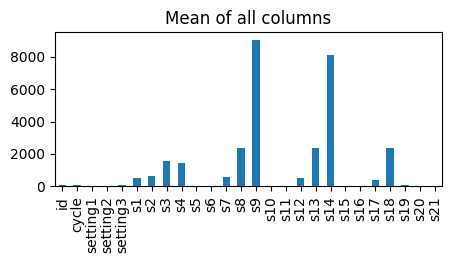

In [25]:
# mean of all columns in terms of barplot
train_df.mean().plot.bar(figsize=(5,2), title="Mean of all columns")


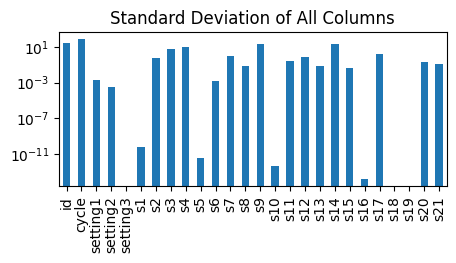

In [26]:
# std of all columns with log transformation.
train_df.std().plot.bar(figsize=(5, 2), logy=True, title="Standard Deviation of All Columns")
# Show the plot
plt.show()

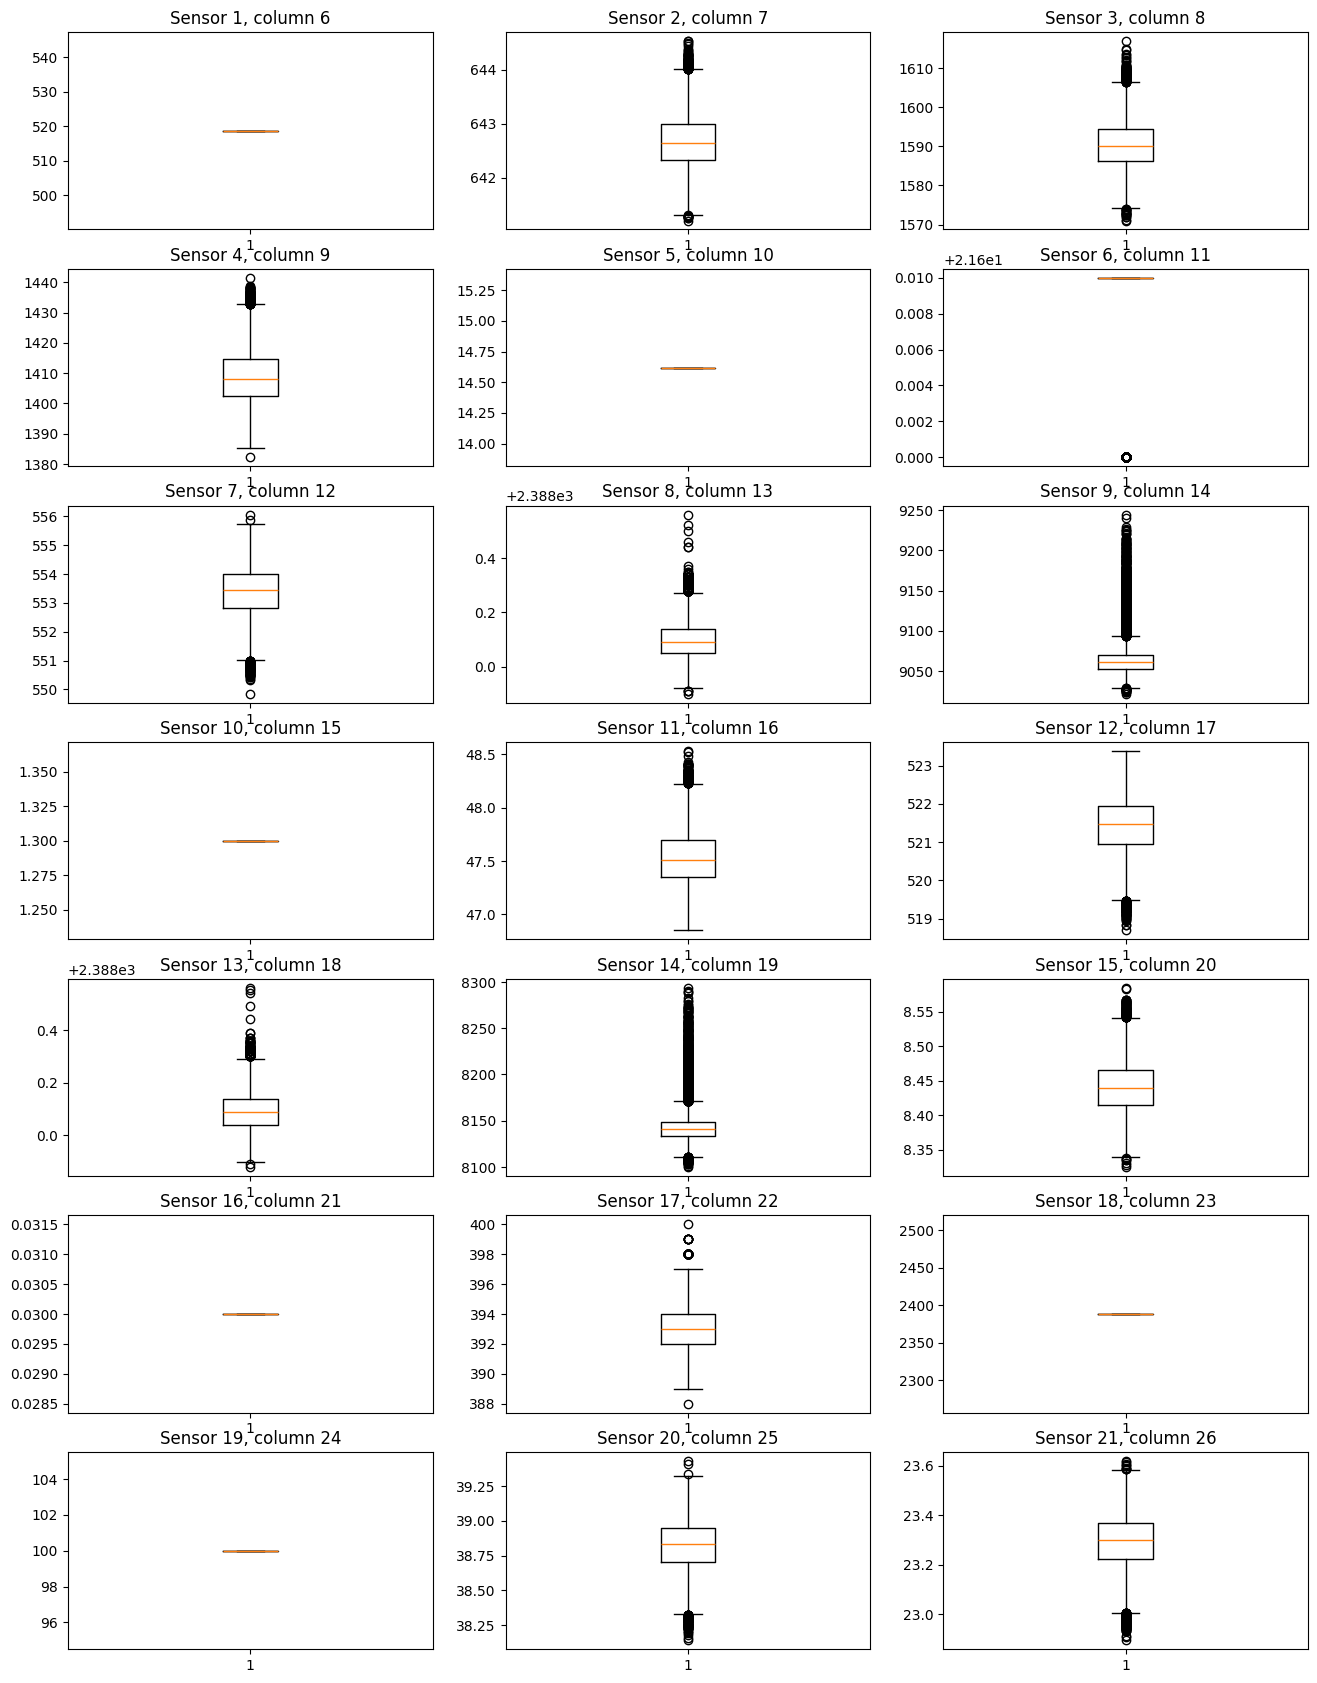

In [27]:
# Boxplots of sensor data
plt.figure(figsize = (16, 21))

for i in range(21):
    sensor_data = train_df.iloc[:,i+5]
    plt.subplot(7,3,i+1)
    plt.boxplot(sensor_data)
    plt.title("Sensor " + str(i+1) + ", column "+ str(i+6))
plt.show()

# This code will visualize the distribution of data for each sensor using boxplots,making it easier to identify outliers, variations, and central tendencies within the data.

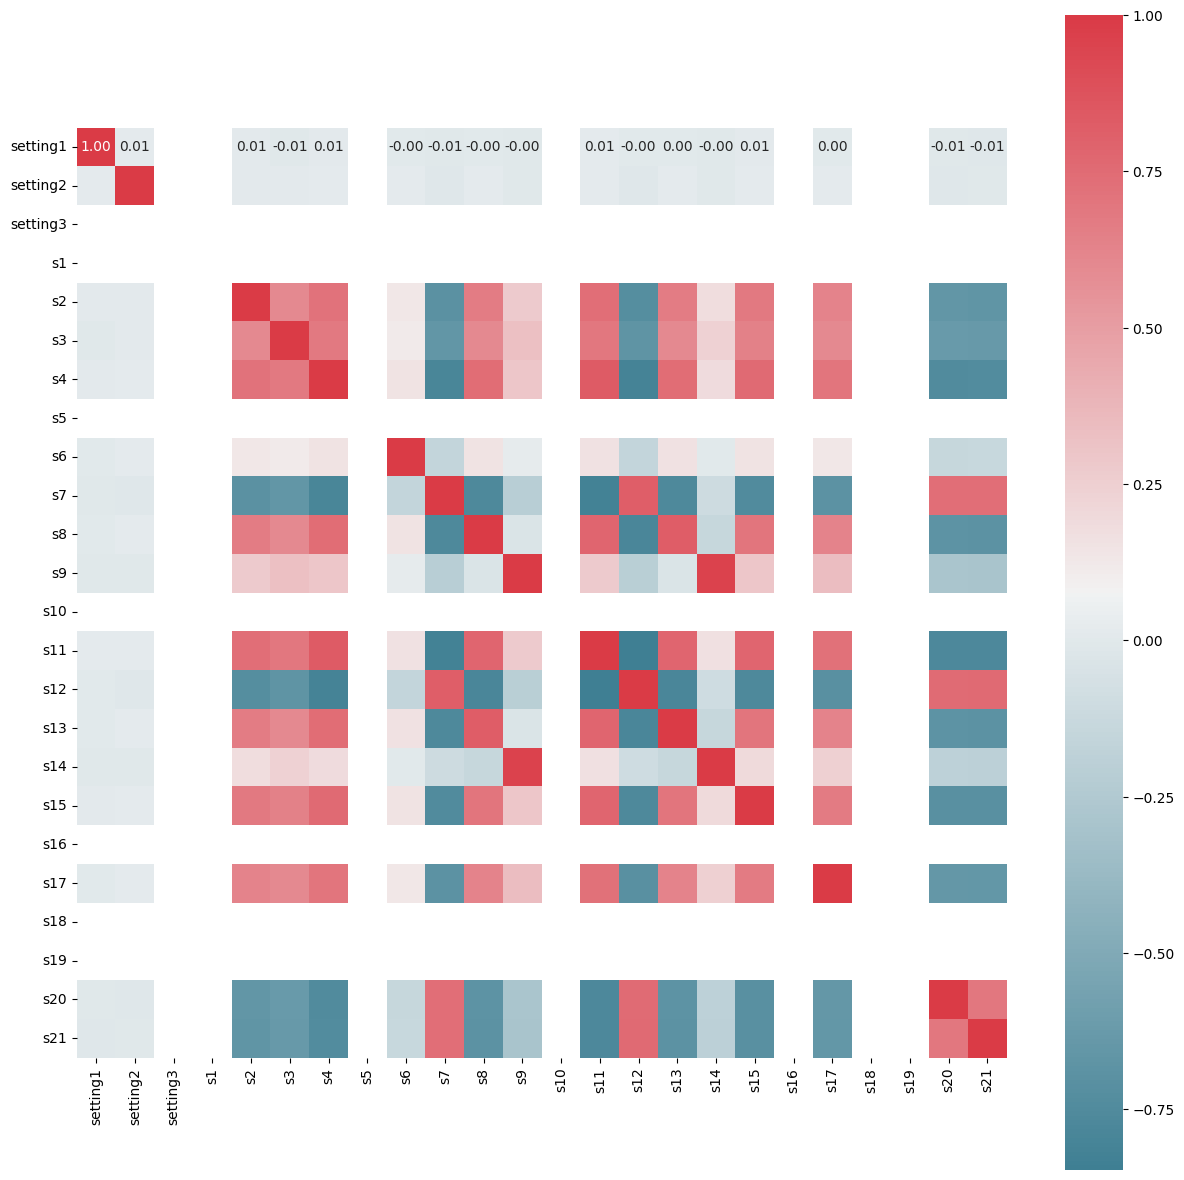

In [28]:
## Correlation of the dataset:
import seaborn as sns

# Selecting the subset of features for which correlation is to be calculated
features = train_df[['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10',
                     's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']]

# Calculating the correlation matrix
corr_plot_variables = features.corr()

f, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(corr_plot_variables, annot=True, fmt='.2f',mask=np.zeros_like(corr_plot_variables, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)

From the above correlation plot between the variables, we could see some features which are constant with time are not having any correlation or they are not considered. features - setting3, S1, S10, S16, S18, S19, S5, S6

Form the above analysis we could say that some features are highly correlated (collinearity between the features) with each other - (S4, S12), (S7, S11), (S7, S12), (S8, S13), (S9, S14) and(S11, S12) some of these features can be ignored when we are modeling with the target variable. 


In [29]:
# Check correlation values for pairs
pairs_to_check = [('s4', 's12'), ('s7', 's11'), ('s7', 's12'), ('s8', 's13'), ('s9', 's14'), ('s11', 's12')]

for pair in pairs_to_check:
    corr_value = features[pair[0]].corr(features[pair[1]])
    print(f"Correlation between {pair[0]} and {pair[1]}: {corr_value}")

#If the correlation values are close to 1 or -1, it indicates high correlation between the features in the pair.

Correlation between s4 and s12: -0.8155905161052351
Correlation between s7 and s11: -0.8228050249957809
Correlation between s7 and s12: 0.8127126013254434
Correlation between s8 and s13: 0.8260843322358072
Correlation between s9 and s14: 0.9631566003059593
Correlation between s11 and s12: -0.8468835930051056










## Pre-processing of the data and Feature Extraction


#### Remaining useful life [RUL] feature extraction from the dataset.

The remaining useful life of the engine is the difference between the maximum cycle of each engine to the current cycle. RUL is the target variable for our Regression task.

#### RUL Feature Train dataset:

In [30]:
# Remaining useful life feature creation for train dataset
data_RUL = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
data_RUL.columns = ['id', 'max_cycle']
train_df = train_df.merge(data_RUL, on=['id'], how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df = train_df.drop('max_cycle', 1)
train_df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...      s13      s14     s15   s16  s17   s18    s19    s20  \
0  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

       s21  RUL  
0  23.4190  191  
1  23.4236  190  
2  23.3442  189  
3  23.3739  188  
4  23.4044  187  

[5 rows x 27 columns]

#### RUL feature for Test Dataset 

For the Test Dataset, we have around 13096 instances that can be used for testing. We are extracting the remaining useful life of an engine for all the instances. Once the RUL is extracted we can use that as a testing dataset. <br>
As per the dataset description in the training set, the fault grows in magnitude until system failure. In the test set, the time series ends sometime before system failure. The objective is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Provided a vector of true Remaining Useful Life (RUL) values for the test data we are reducing the test set to the exact True RUL cycles.

In [31]:
#RUL feature for Test Dataset
valid_data = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
valid_data.columns = ['id', 'last_cycle']
df_truth_data = pd.merge(test_df, valid_data, on='id')
df_truth_data = df_truth_data[df_truth_data['cycle'] == df_truth_data['last_cycle']]
df_truth_data = df_truth_data.drop(['last_cycle'],1)
df_truth_data.reset_index(drop=True, inplace=True)
df_truth_data = pd.concat([df_truth_data, truth_df], axis=1)
df_test_data = df_truth_data.rename(columns={'time-to-failure': 'RUL'})
df_test_data.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1     31   -0.0006    0.0004     100.0  518.67  642.58  1581.22  1398.91   
1   2     49    0.0018   -0.0001     100.0  518.67  642.55  1586.59  1410.83   
2   3    126   -0.0016    0.0004     100.0  518.67  642.88  1589.75  1418.89   
3   4    106    0.0012    0.0004     100.0  518.67  642.78  1594.53  1406.88   
4   5     98   -0.0013   -0.0004     100.0  518.67  642.27  1589.94  1419.36   

      s5  ...      s13      s14     s15   s16  s17   s18    s19    s20  \
0  14.62  ...  2388.06  8130.11  8.4024  0.03  393  2388  100.0  38.81   
1  14.62  ...  2388.09  8126.90  8.4505  0.03  391  2388  100.0  38.81   
2  14.62  ...  2388.14  8131.46  8.4119  0.03  395  2388  100.0  38.93   
3  14.62  ...  2388.11  8133.64  8.4634  0.03  395  2388  100.0  38.58   
4  14.62  ...  2388.15  8125.74  8.4362  0.03  394  2388  100.0  38.75   

       s21  RUL  
0  23.3552  112  
1  23.2618   98  
2  23.2740   69  
3  23.2581   82  
4  23.4117   91  

[5 rows x 27 columns]

## Correlation analysis with Target variable

In [32]:
# correlation of the all features with the RUL variable. 
# Iterate over each column in train_df
for col in train_df.columns:
    # Convert column values to numeric
    train_df[col] = pd.to_numeric(train_df[col],errors='coerce')
# Select correlation coefficients corresponding to RUL and sort them and Print correlation coefficients sorted in descending order
corr_m = train_df.corr()
corr_m['RUL'].sort_values(ascending=False)

RUL         1.000000
s12         0.671983
s7          0.657223
s21         0.635662
s20         0.629428
id          0.078753
setting2   -0.001948
setting1   -0.003198
s6         -0.128348
s14        -0.306769
s9         -0.390102
s13        -0.562569
s8         -0.563968
s3         -0.584520
s17        -0.606154
s2         -0.606484
s15        -0.642667
s4         -0.678948
s11        -0.696228
cycle      -0.736241
setting3         NaN
s1               NaN
s5               NaN
s10              NaN
s16              NaN
s18              NaN
s19              NaN
Name: RUL, dtype: float64

## Visualizations of the Data

### Distribution plots of all variables with respective to the Target variable

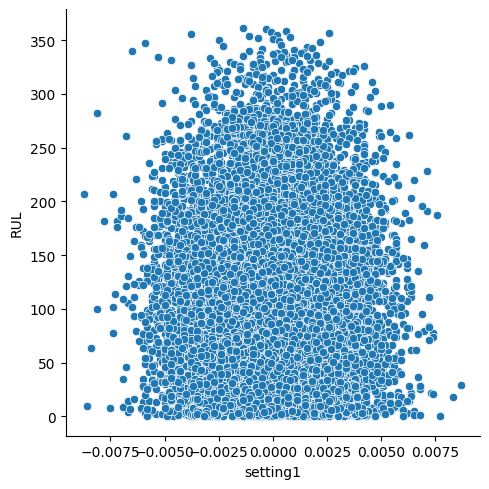

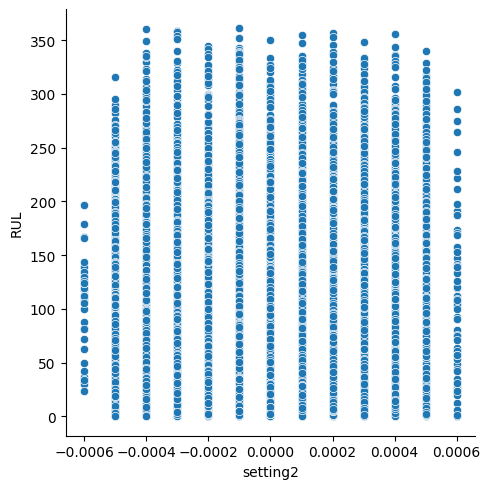

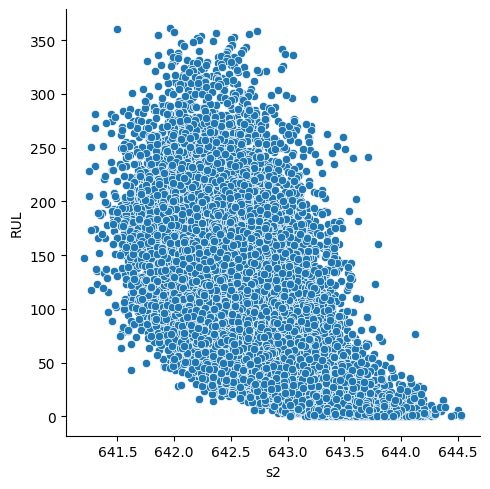

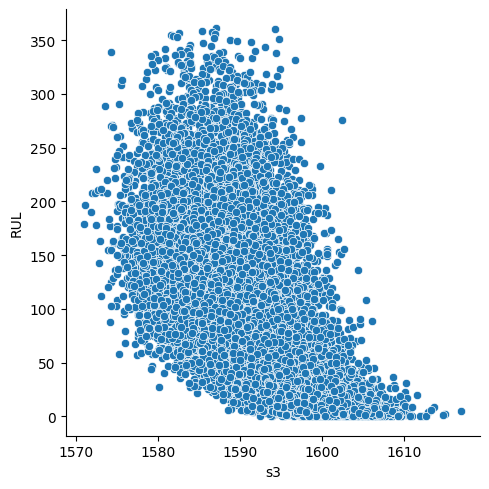

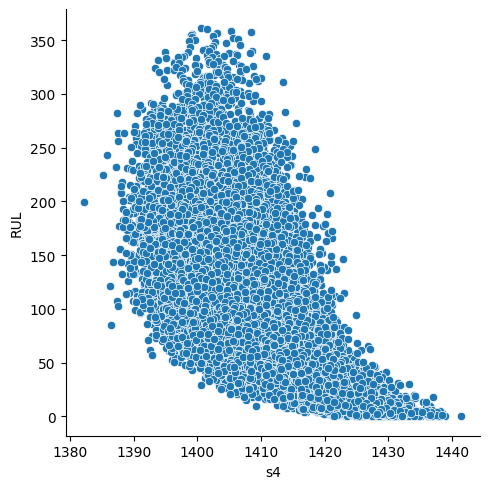

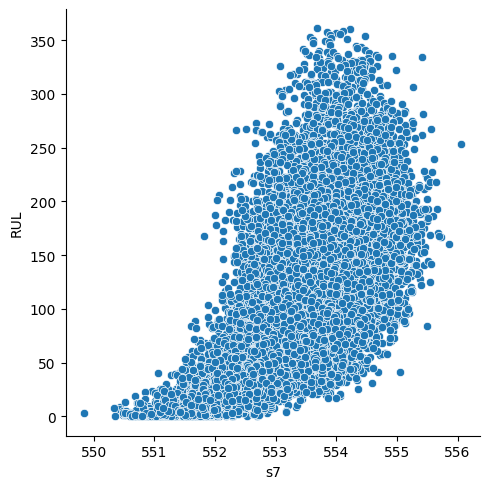

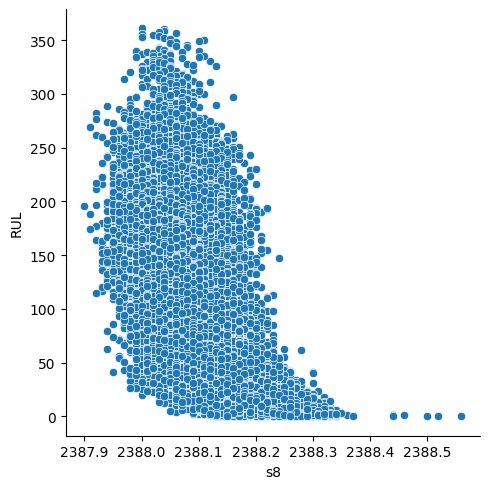

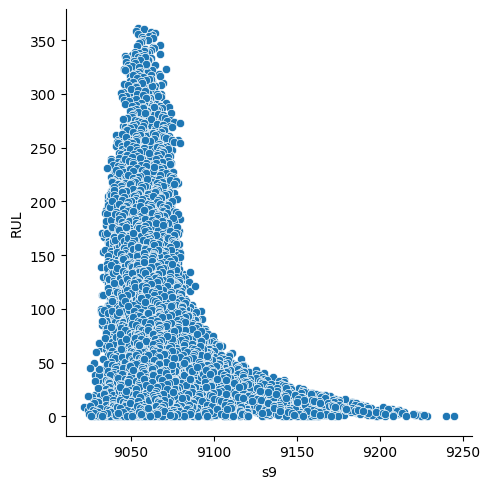

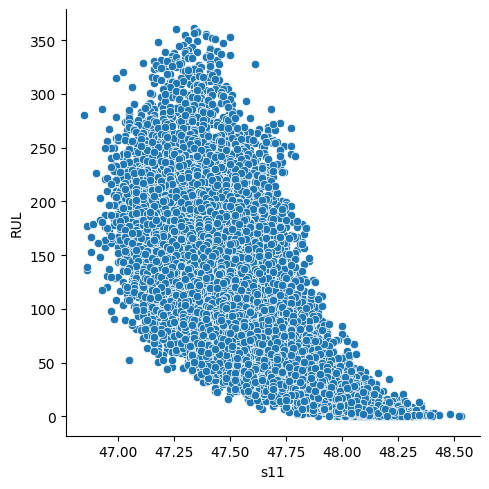

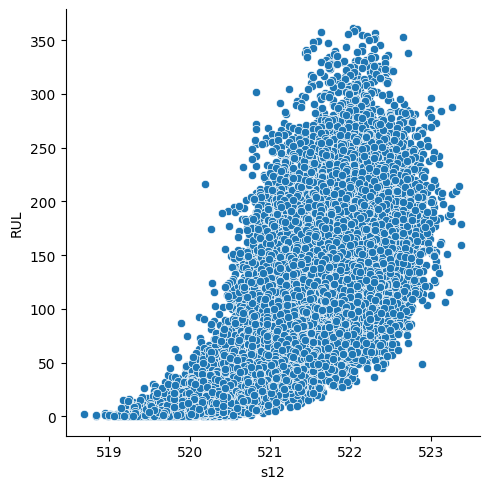

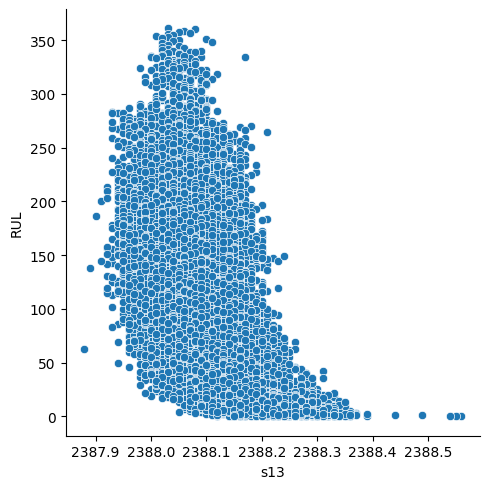

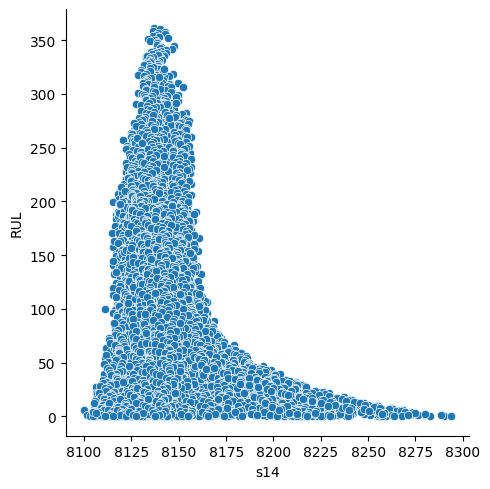

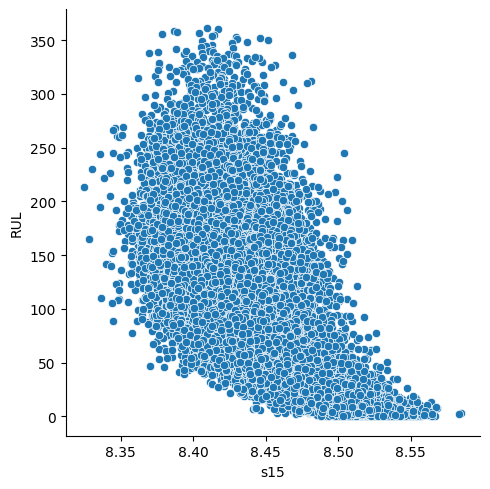

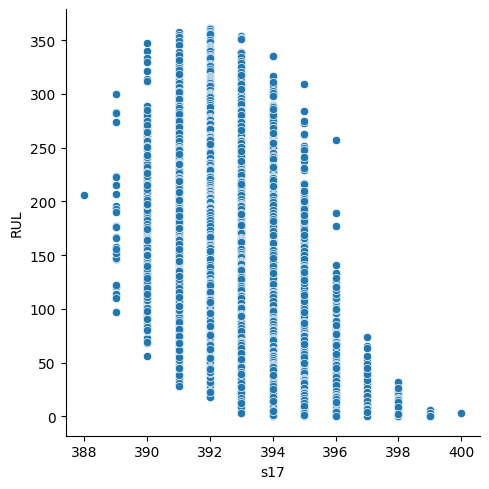

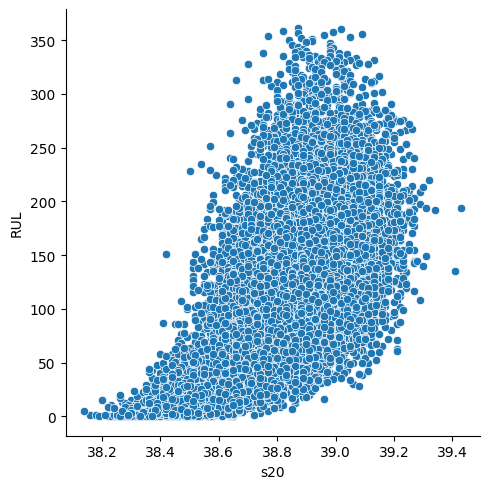

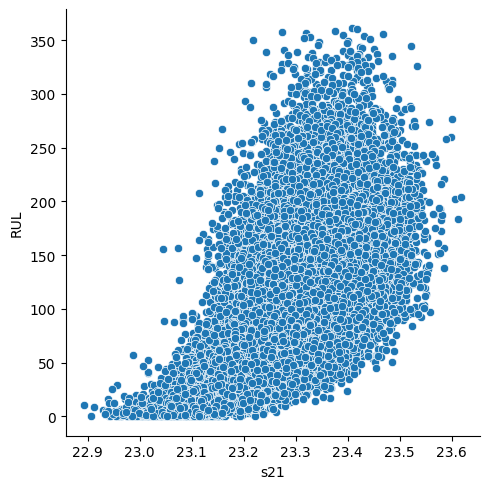

In [33]:
attributes = ['setting1','setting2','s2','s3','s4','s7','s8','s9','s11',
                                               's12','s13','s14','s15','s17','s20','s21']
for i in range(len(attributes)):
    sns.relplot(x=attributes[i], y="RUL", data=train_df)

### Scatter Plot visualizations of the attributes with each other. 

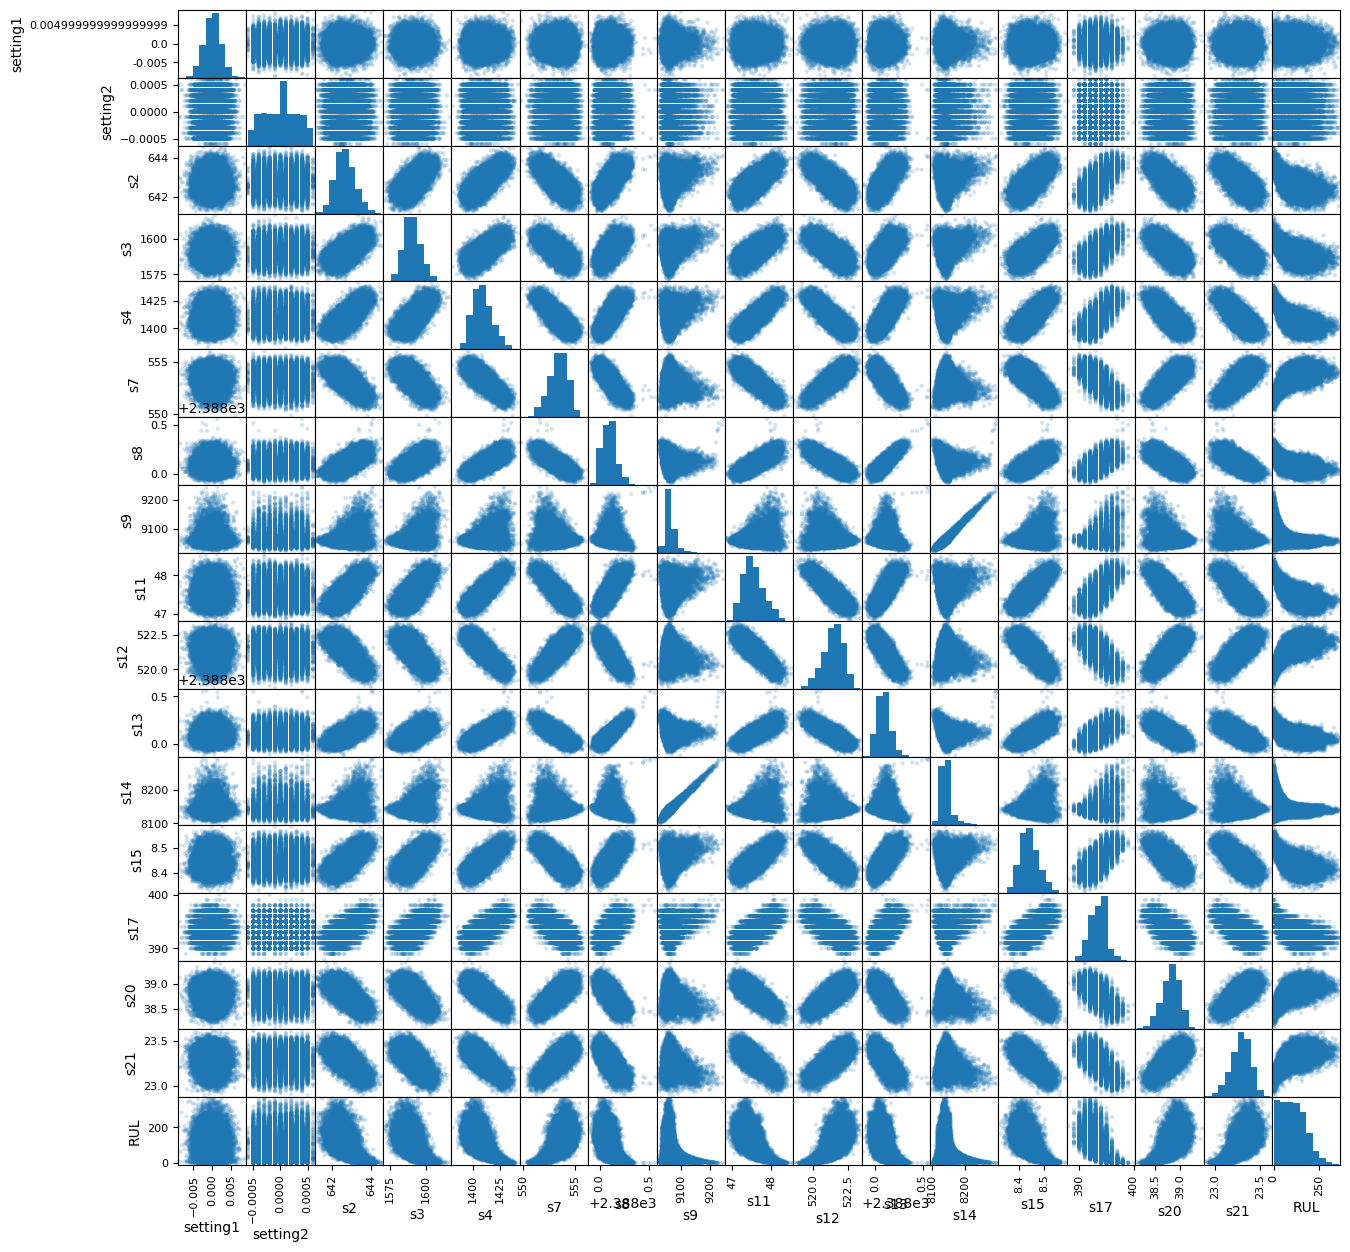

In [34]:
## Scatter Plot 
from pandas.plotting import scatter_matrix
attributes = ['setting1','setting2','s2','s3','s4','s7','s8','s9','s11',
                                               's12','s13','s14','s15','s17','s20','s21','RUL']
fig = scatter_matrix(train_df[attributes],alpha=0.2, figsize=(15, 15))
plt.show()

From the scatter plots we could see that the data is distributed normally few variables are skewed. The relationship with the target variable is not linear for most of the variables. Most of the variables are non-linear with the target variable RUL.

### Sensor data Visualizations for some random engines

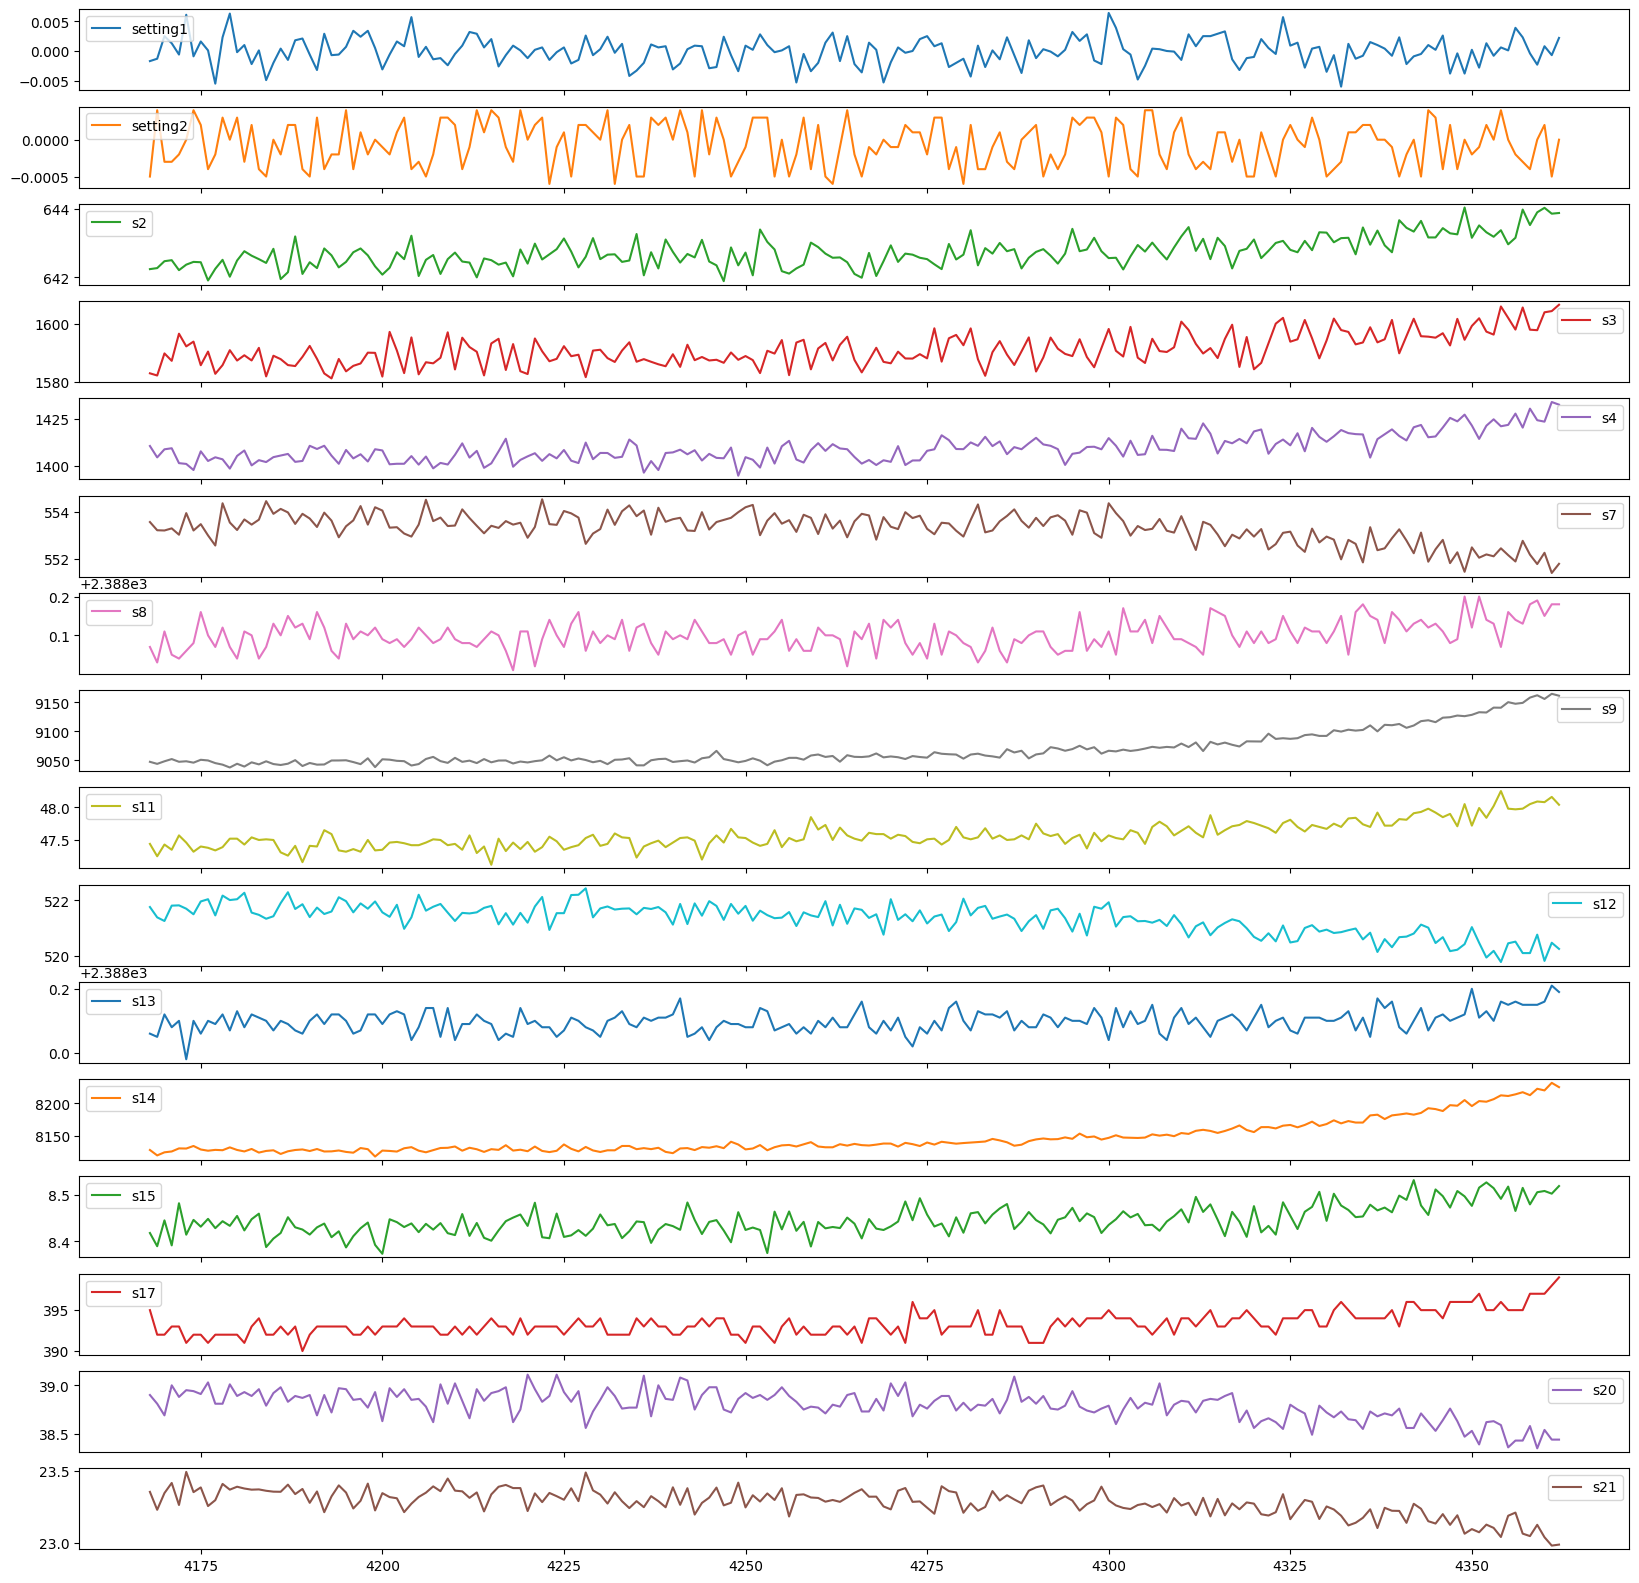

In [35]:
#for random engine num 21
id_21 = train_df[train_df['id'] == 21]

# few sensor values are ignores since they don't change with time 
feature_col = ['setting1','setting2','s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20','s21']
id_21 = id_21[feature_col]

# Plotting selected sensor values over time
id_21_plot = id_21.plot(subplots=True, sharex=True, figsize=(20,20))

# Modelling

Remaining Useful Life estimation with RUL models considers the following categories and the RUL models are useful when the historical data and information is available:

1. Run to failure histories of machines similar to machines which is will be diagnosed. 
2. A known threshold value of some condition indicator that indicates the failure. 
3. Data about how much time it took for a similar machine to reach failure. 

RUL estimation models provide methods for training the model using historical data and using it for performing prediction of the remaining useful life.

similarity models are one of the RUL estimation model, where RUL prediction of a test machine can be done on the known behavior of similar machines from a historical database. Such models compare a trend in test data or condition-indicator values to the same information extracted from a similar system.

Here, the Regression task is to predict the remaining useful component of life. The remaining useful life estimates are in the units if time (cycles/hours/mileage). We have used Linear and non - linear models to predict the Time To Failure of a machine.

### Regression anaylysis

1. <b>Linear Regression:</b> It is a statistical process for estimating the relationship between dependent variable (target) and one or more independent variables. This method is also called the least-squares regression, the most common method for fitting the regression line is the method of least squares. linear regression calculates the best-fitting line for the observed data by minimizing the sum of the squares of vertical deviations forms each data point to the line. 

2. <b>Decision tree Regression:</b> Decision tree is a hierarchical model that splits the dataset into several branches taking the maximum information from each split. Regression Tress are used for continuous output, In the regression tree, the value is obtained by the terminal nodes in the training data is the mean response of the observation. 

3. <b>Polynomial Regression:</b> It is a statistical method of regression analysis in which the relationship between the independent variable x and dependent variable y is modeled as an nth degree polynomial in x.

4. <b>Lasso Regression:</b> It is a type of Linear Regression that used shrinkage, the data values are shrunk towards a central point. It minimizes the sum of the squared errors and also penalizing the L1 norm of the coefficients. 

5. <b>RandomForest Regression:</b> RandomForest is a ensemble method of regression trees. The regression trees run in parallel and there is no interaction between these trees while building the trees. RandomForest regression trees output the mean prediction of the individual trees. 

6. <b>LGBM Regression</b> LightGBM is a gradient boosting tree-based learning algorithm which is distributed and efficient. It is designed to have faster training speed, efficiency, low memory usage, better accuracy and it is capable of handling large datasets. 

7. <b>XGBoost Regressor</b> XGBoost is an optimized distributed gradient boosting algorithm which is highly efficient and flexible. It is also a parallel tree-based learning/boosting which is fast and accurate. This model is used for supervised learning problems like regression and classification. 

8. <b>CatBoost Regressor</b> CatBoost is a machine learning algorithm that uses gradient boosting on tree-based learning (decision trees). CatBoost can stop the training earlier than the training parameters dictate to avoid overfitting of the data. 

<b>Metrics:</b>

The metrics used for measuring the above models are R-squared (R2_score), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean Squared Error (MSE).

1. <b>R2_score:</b> It is known as the coefficient of the determination. R-squared is a statistical measure of how close the data are to the fitted regression line. 
R-squared is always between 0 and 100%:<br>
 ==> 0% indicates that the model explains none of the variability of the response data around its mean.<br>
 ==> 100% indicates that the model explains all the variability of the response data around its mean.<br>

2. <b>RMSE:</b> It indicates the measure of how accurately the model predicts the response. The lower the value of RMSE the better is the model performance.

3. <b>MAE:</b> It indicates the average magnitude of the errors in a set of predictions.

4. <b>MSE:</b> It measures the average of the squares of the errors, the average squared difference between the estimated values and the actual value.



In [36]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from numpy import mean
from numpy import std
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#### Feature selection for the model

We have selected the below list of features as they are correlated with the target variable. 
Few variables are dropped because they are constant with time and they do not have any 
correlation with the target variable.


In [37]:
features = ['setting1','setting2','s2','s3','s4','s7','s8','s9','s11','s12','s13','s14','s15','s17','s20','s21']

#Features which are constant with time are not considered for modelling 


### Splitting of Train and Test Data

Here, train data is used for the training the machine learning model, and Test/Truth data is used for the validation. 

In [38]:
X_train = train_df[features]
y_train = train_df['RUL']

X_test = df_test_data[features]
y_test = df_test_data['RUL']
#features_orig = ['op_setting1','op_setting2','op_setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
#features = features_orig

In [39]:
X_train.shape

(20631, 16)

In [40]:
y_train.shape

(20631,)

In [41]:
X_test.shape

(100, 16)

In [42]:
y_test.shape

(100,)

In [43]:
x_train_num = X_train.select_dtypes(include=np.number)

#Selecting categorical dataframe in train set
x_train_cat = X_train.select_dtypes(exclude=['number'])

<b>Pipeline and Scalar Selection</b> Since we have only numerical variables in the data, the pipeline is constructed with the numerical data. If there are too many outliers in the data then they will influence the mean and max value or min value. we have used the RobustScaler, It removes the median from the data and scales the data by the InterQuartile Range(IQR). 

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0)),('robust_scalar',RobustScaler()),])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent', fill_value=0)),('onehot', 
                                                                                OneHotEncoder(handle_unknown='ignore')),])

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(x_train_num.columns)
cat_attribs = list(x_train_cat.columns)

#full pipeline of numeric attributes
full_pipeline = ColumnTransformer([("num",num_pipeline,num_attribs), ("cat",cat_pipeline,cat_attribs)])

#Using full_pipeline perform fit and transform on training data
x_train_prepared = full_pipeline.fit_transform(X_train)

In [46]:
x_test_prepared = full_pipeline.transform(X_test)
x_train_prepared.shape

(20631, 16)

In [47]:
x_test_prepared.shape

(100, 16)

## Linear Regression 

We have used all the parameters available in the model (intercept, normalize). We have applied the modeling on the training data and test as well. Cross-validation is computed using the Repeated k-fold CV. mean of the neg_mean_absolute_error and std of the scores is calculated. Cross-Validation scores for the 3 repetitions are calculated and are shown below.

In [48]:
#Linear regression
model_linear = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None)
model_linear.fit(x_train_prepared, y_train)
model_linear_train_predictions = model_linear.predict(x_train_prepared)
model_linear_test_predictions = model_linear.predict(x_test_prepared)

print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, model_linear_test_predictions)**0.5))
print('Mean Absolute Error:', (metrics.mean_absolute_error(y_test, model_linear_test_predictions)))

print("r2_score on Train data :", r2_score(y_train,model_linear_train_predictions)) 
print("r2_score on Test data :", r2_score(y_test,model_linear_test_predictions)) 
print(' ')
print("Cross Validation on Training Data")
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_linear, x_train_prepared, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, 
                                                                                                     error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("Cross validation score:", cross_val_score(model_linear, x_train_prepared, y_train, cv=cv))

Root Mean Squared Error: 32.04274103205499
Mean Absolute Error: 25.59380624989196
r2_score on Train data : 0.5794932912981681
r2_score on Test data : 0.4054344040526623
 
Cross Validation on Training Data
MAE: -34.143 (0.717)
Cross validation score: [0.6085437  0.57880665 0.5809385  0.5602833  0.57428878 0.59029114
 0.55806617 0.56772493 0.59564827 0.57106705 0.58910054 0.59017042
 0.58216042 0.59897169 0.59212836 0.58170093 0.55216635 0.56082849
 0.57219257 0.56467575 0.57080056 0.57456876 0.57066856 0.55970919
 0.58155557 0.57477407 0.59454576 0.59137234 0.58073174 0.58952339]


<b>Residuals</b> The Residuals are defined as the difference between the observed value of the dependent variable (y) and the predicted value (ŷ) is called the residual. Each data point has one residual and the residuals are plotted for the test data. Here, the residulas are shown along the y-axis and the independent variables are shown along the x-axis.

In [49]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


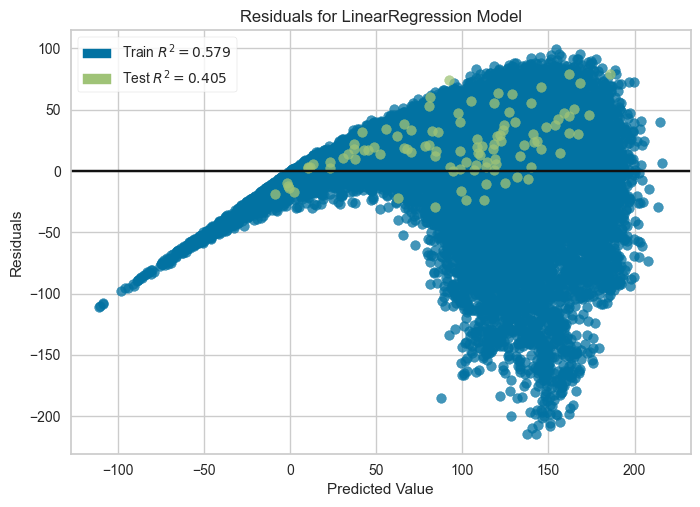

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [50]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model_linear, hist=False)

visualizer.fit(x_train_prepared, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test_prepared, y_test)  # Evaluate the model on the test data
visualizer.show()   

<b>Prediction error</b> is nothing but how well the model performs to predict the response variable. We have calculated the prediction and plotted the residuals along the regression line. The below graph shows the prediction error for the test with an r2_score of 0.405.

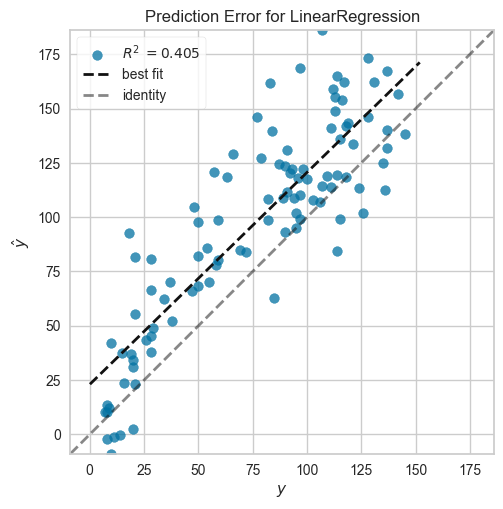

In [51]:
from yellowbrick.regressor import prediction_error
visualizer = prediction_error(model_linear, x_train_prepared, y_train, x_test_prepared, y_test)

<b>Actual vs Prediction</b> The below shows the plotted graph for the engine numbers along the x-axis and the number of cycles along the y-axis. 
The graph shows a plotted comparison of actual and predicted samples.   

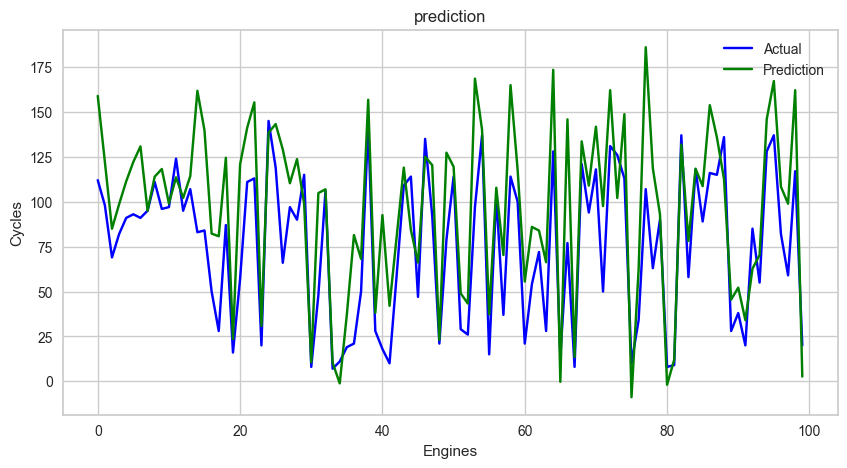

In [52]:
fig = plt.figure(figsize=(10, 5))
plt.plot(y_test, color="blue")
plt.plot(model_linear_test_predictions, color="green")
plt.title('prediction')
plt.ylabel('Cycles')
plt.xlabel('Engines')
plt.legend(['Actual', 'Prediction'], loc='upper right')
plt.show()

## Polynomial Regression

Polynomial regression extracts a new feature matrix consisting of all polynomial combinations of the features with a degree less than or equal to the specified degree. here, the degree is 2 which is the default value. The scores are good with the default value of the degree. K-fold cross-validation is also done with 3 repetitions. 

Polynomial regression with degree 2 has shown better performance than the linear regression model with improved r2_score and RMSE with the test data samples.

In [53]:
#polynomial regression
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_train_prepared_poly = poly_features.fit_transform(x_train_prepared)
x_test_prepared_poly = poly_features.fit_transform(x_test_prepared)
poly_reg = LinearRegression()
poly_reg.fit(x_train_prepared_poly, y_train)
poly_reg_train_predict = poly_reg.predict(x_train_prepared_poly)
poly_reg_test_predict = poly_reg.predict(x_test_prepared_poly)
print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, poly_reg_test_predict)**0.5))
print('Mean Absolute Error:', (metrics.mean_absolute_error(y_test, poly_reg_test_predict)))
print("r2_score on Train data :", r2_score(y_train,poly_reg_train_predict)) 
print("r2_score on Test data :", r2_score(y_test,poly_reg_test_predict)) 
print(' ')
print("Cross Validation on Training Data")
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(poly_reg, x_train_prepared, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, 
                                                                                                error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("Cross validation score:", cross_val_score(poly_reg, x_train_prepared_poly, y_train, cv=cv))

Root Mean Squared Error: 31.284620963089033
Mean Absolute Error: 23.845612331371026
r2_score on Train data : 0.6269041117496396
r2_score on Test data : 0.4332360076266615
 
Cross Validation on Training Data
MAE: -34.143 (0.717)
Cross validation score: [0.64932443 0.62318191 0.62273919 0.60899291 0.61973574 0.6313079
 0.60394084 0.61572405 0.63251219 0.60914242 0.63408015 0.63376826
 0.62411375 0.6439574  0.62899706 0.61900402 0.60165096 0.59997267
 0.61595728 0.61141103 0.61529384 0.60981144 0.61763886 0.59865034
 0.62418483 0.62197957 0.64024372 0.62824    0.62212432 0.63723807]


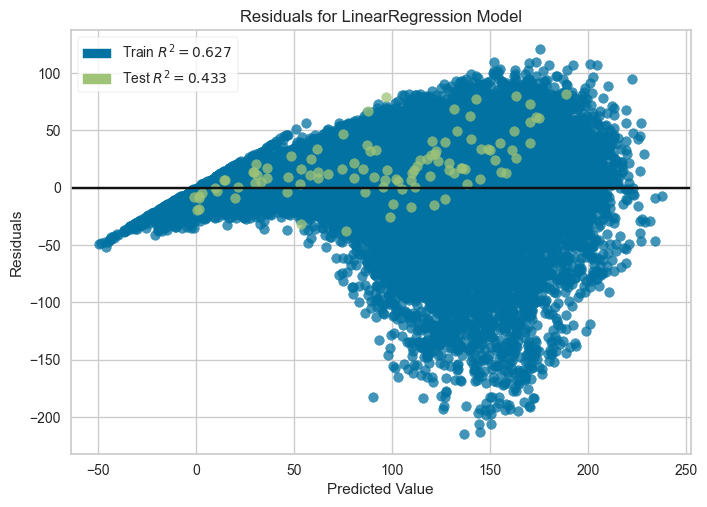

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [54]:
visualizer = ResidualsPlot(poly_reg, hist=False)
visualizer.fit(x_train_prepared_poly, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test_prepared_poly, y_test)  # Evaluate the model on the test data
visualizer.show()  

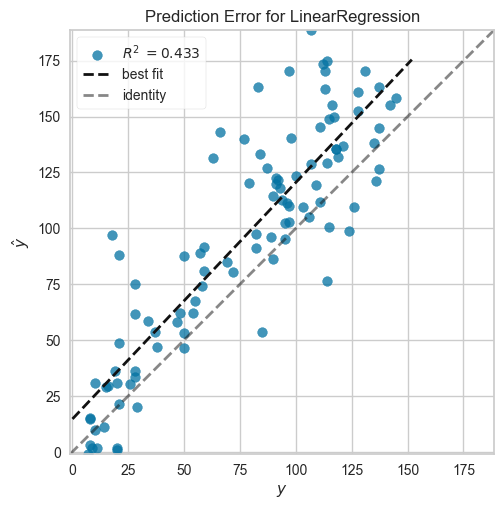

In [55]:
visualizer = prediction_error(poly_reg, x_train_prepared_poly, y_train, x_test_prepared_poly, y_test)

## Actual vs predicted output values for the Polynomial Regression model.

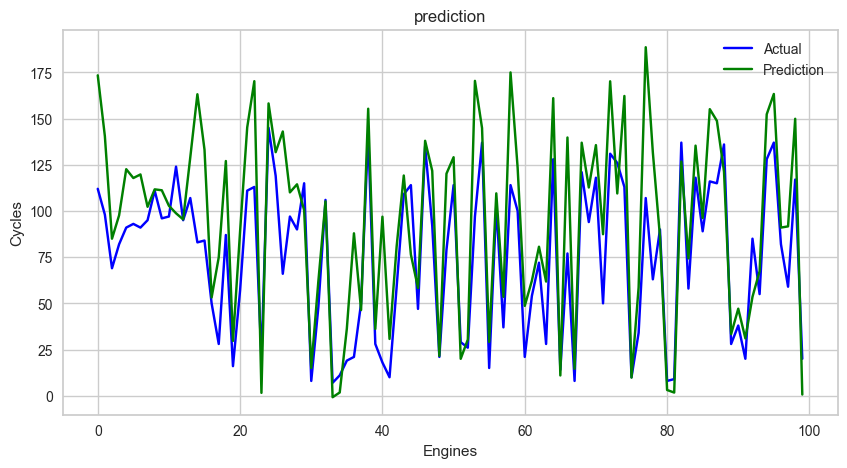

In [56]:
fig = plt.figure(figsize=(10, 5))
plt.plot(y_test, color="blue")
plt.plot(poly_reg_test_predict, color="green")
plt.title('prediction')
plt.ylabel('Cycles')
plt.xlabel('Engines')
plt.legend(['Actual', 'Prediction'], loc='upper right')
plt.show() 

## DecisionTree Regression

Decision tree regression is a non-linear model with tree-based learning. The data is somewhat non-linear with the target variable, which is a good model to predict the results. Without parameter tuning the algorithm has produced comparatively good results than the linear regression model. 

Randomized search parameter tuning has been performed on the decision tree regression which improved the results in a good manner. RepeatedKFold cross-validation with neg_mean_absolute_error and cross-validation score has been calculated. cross-validation seems to be giving good scores on training data which is equal to actual scores. 

In [57]:
model_dt = DecisionTreeRegressor(max_depth=7)
# fit the model on the whole dataset
model_dt.fit(x_train_prepared, y_train)
model_dt_train_predictions = model_dt.predict(x_train_prepared)
model_dt_test_predictions = model_dt.predict(x_test_prepared)

print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, model_dt_test_predictions)**0.5))
print('Mean Absolute Error:', (metrics.mean_absolute_error(y_test, model_dt_test_predictions)))

print("r2_score on Train data :", r2_score(y_train,model_dt_train_predictions)) 
print("r2_score on Test data :", r2_score(y_test,model_dt_test_predictions)) 
print(' ')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_dt, x_train_prepared, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("Cross validation score:", cross_val_score(model_dt, x_train_prepared, y_train, cv=cv))

Root Mean Squared Error: 32.09534866534591
Mean Absolute Error: 24.319067970898036
r2_score on Train data : 0.6247808966557462
r2_score on Test data : 0.4034804909704117
 
MAE: -31.620 (0.681)
Cross validation score: [0.62397856 0.5936928  0.59818302 0.57378783 0.58455255 0.59823643
 0.58070199 0.58644068 0.59025384 0.58897083 0.6070233  0.60093698
 0.59440316 0.61454731 0.59041014 0.59579157 0.56640682 0.580808
 0.59037973 0.59593764 0.58461942 0.58084814 0.5919243  0.57949679
 0.58997844 0.58359468 0.61634951 0.60006144 0.58958829 0.60723695]


## DecisionTreeRegression with Parameter Tunning.

In [58]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
# Initialize your model
model_dt = DecisionTreeRegressor()

# Define hyperparameters for RandomizedSearchCV
parameters = {"criterion": ["mse", "mae","poisson"],
              "min_samples_split": [2, 4, 6, 8, 10],
              "max_depth": [2, 3, 4, 5, 6, 7, 8],
              "min_samples_leaf": [1, 2, 3, 4, 5]}

# Perform hyperparameter tuning
dt_model = RandomizedSearchCV(model_dt, parameters, verbose=2, random_state=42, n_jobs=-1)
dt_model.fit(x_train_prepared, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae', 'poisson'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8],
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 4, 6, 8, 10]},
                   random_state=42, verbose=2)

In [59]:
dt_model.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_depth': 8,
 'criterion': 'poisson'}

In [60]:
dt_model_train_predictions = dt_model.predict(x_train_prepared)
dt_model_test_predictions = dt_model.predict(x_test_prepared)

print("r2_score on Train data :", r2_score(y_train,dt_model_train_predictions)) 
print("r2_score on Test data :", r2_score(y_test,dt_model_test_predictions)) 

print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, dt_model_test_predictions)**0.5))
print('Mean Absolute Error:', (metrics.mean_absolute_error(y_test, dt_model_test_predictions)))

r2_score on Train data : 0.6339763310445431
r2_score on Test data : 0.25696001578818195
Root Mean Squared Error: 35.82084812396083
Mean Absolute Error: 26.77708399551578


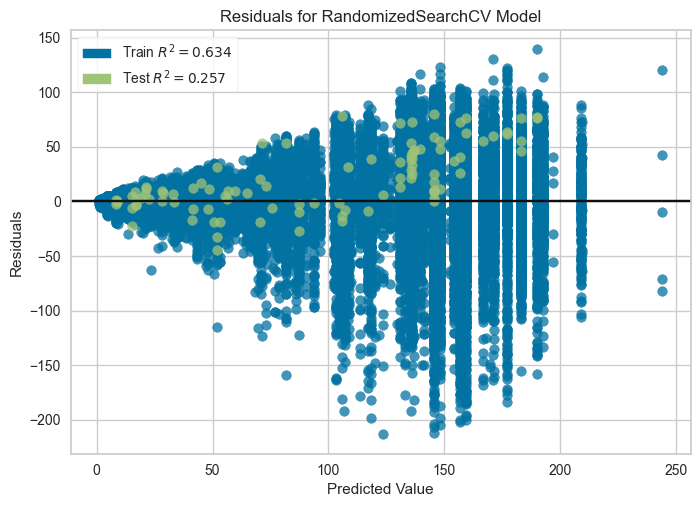

<Axes: title={'center': 'Residuals for RandomizedSearchCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [61]:
visualizer = ResidualsPlot(dt_model, hist=False)
visualizer.fit(x_train_prepared, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test_prepared, y_test)  # Evaluate the model on the test data
visualizer.show()  

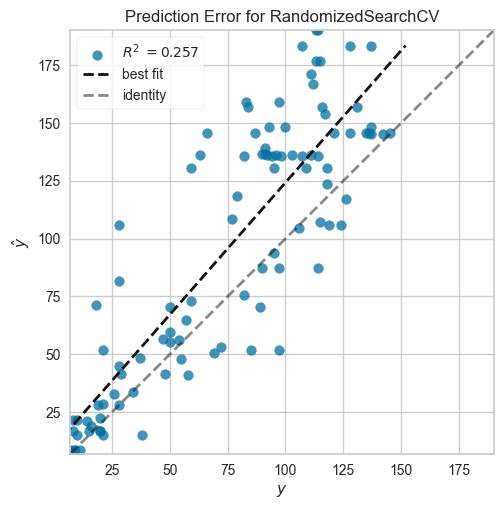

In [62]:
visualizer = prediction_error(dt_model, x_train_prepared, y_train, x_test_prepared, y_test)

## <font color = red> Actual vs predicted output values for the Decision tree regression model.</font>

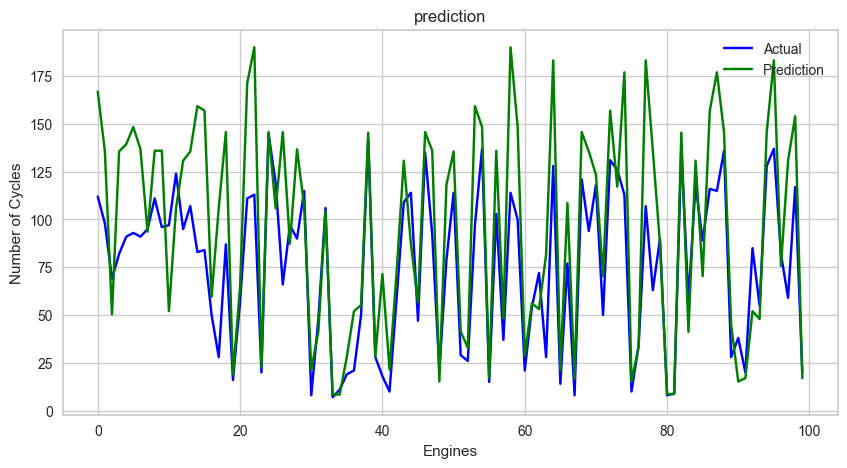

In [63]:
fig = plt.figure(figsize=(10, 5))
plt.plot(y_test, color="blue")
plt.plot(dt_model_test_predictions, color="green")
plt.title('prediction')
plt.ylabel('Number of Cycles')
plt.xlabel('Engines')
plt.legend(['Actual', 'Prediction'], loc='upper right')
plt.show() 

## Lasso Regression

Lasso Regression is a type of regression technique in which both variable selection and regularization happen simultaneously. In this method, a penalty will be applied which will affect the value of the coefficient of regression. The results are produced equally with the linear regression model. The data seems to be the same with no change even though we have applied with the parameter alpha (0.01).

As the tuning parameter increases the bias increases and when the tuning parameter decreases variance increases. RepeatedKFold cross-validation is performed which is giving good scores on training data which is equal to actual scores. 

In [64]:
#Lasso regression
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(x_train_prepared, y_train)
model_lasso_train_predictions = model_lasso.predict(x_train_prepared)
model_lasso_test_predictions = model_lasso.predict(x_test_prepared)
print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, model_lasso_test_predictions)**0.5))
print('Mean Absolute Error:', (metrics.mean_absolute_error(y_test, model_lasso_test_predictions)))
print("r2_score on Train data :", r2_score(y_train,model_lasso_train_predictions)) 
print("r2_score on Test data :", r2_score(y_test,model_lasso_test_predictions)) 
print(' ')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_lasso, x_train_prepared, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, 
                                                                                           error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("Cross validation score:", cross_val_score(model_lasso, x_train_prepared, y_train, cv=cv))

Root Mean Squared Error: 32.040020705119495
Mean Absolute Error: 25.593458887488367
r2_score on Train data : 0.5794931052623815
r2_score on Test data : 0.405535353228474
 
MAE: -34.143 (0.717)
Cross validation score: [0.60851565 0.57879091 0.5809357  0.56030258 0.57430205 0.59029501
 0.55807059 0.56773379 0.59566189 0.57108391 0.58909338 0.59016744
 0.5821707  0.59897488 0.59211532 0.58171435 0.55217609 0.5608538
 0.57217435 0.56466251 0.57080703 0.57457964 0.57065806 0.55973113
 0.58157013 0.5747839  0.59454514 0.59136309 0.58073403 0.58952857]


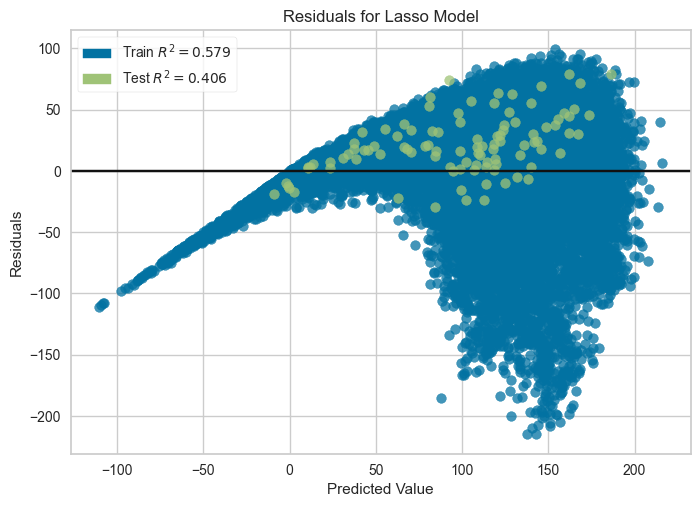

<Axes: title={'center': 'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [65]:
visualizer = ResidualsPlot(model_lasso, hist=False)
visualizer.fit(x_train_prepared, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test_prepared, y_test)  # Evaluate the model on the test data
visualizer.show() 

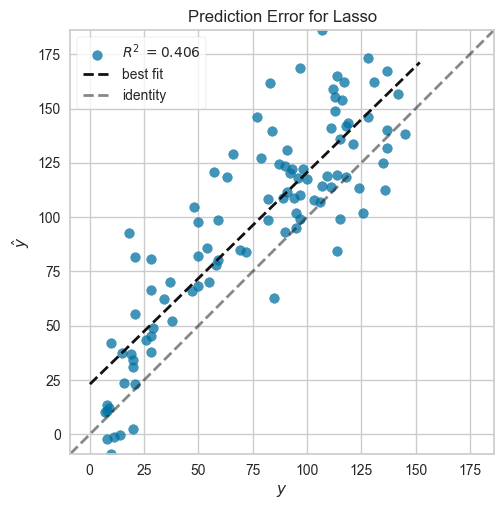

In [66]:
visualizer = prediction_error(model_lasso, x_train_prepared, y_train, x_test_prepared, y_test)

## Actual vs predicted output values for the Lasso Regression model.

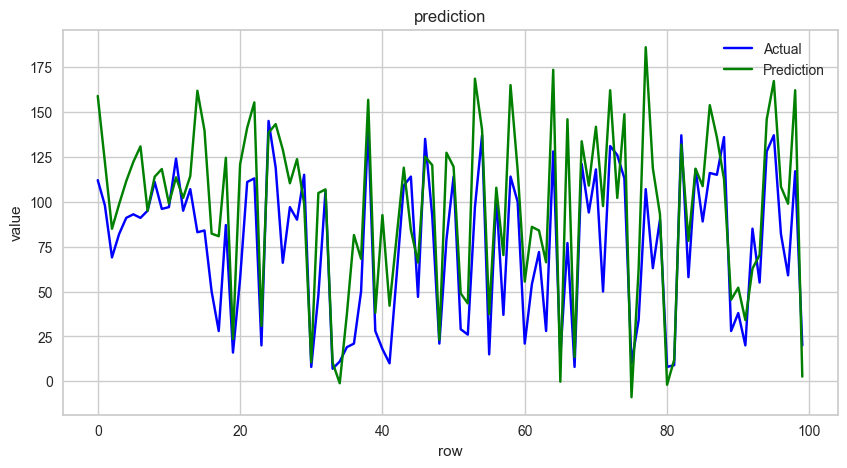

In [67]:
fig = plt.figure(figsize=(10, 5))
plt.plot(y_test, color="blue")
plt.plot(model_lasso_test_predictions, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['Actual', 'Prediction'], loc='upper right')
plt.show() 

## Randomforest Regression

Random forest regression is an ensemble method that is capable of constructing a multitude of decision trees for performing a regression task which is called Bootstrap aggregation (bagging). It involves training each decision tree on a different data sample. Random forest regression without parameter tuning has given relatively poor results than the normal linear models. 

RandamisedSearch parameter tuning has given good results and performed better than any other model giving test scores(r2_score) highest(0.4937). 

In [68]:
from sklearn.ensemble import RandomForestRegressor
randf = RandomForestRegressor(max_depth=7)
randf.fit(x_train_prepared, y_train)
model_random_train_predictions = randf.predict(x_train_prepared)
model_random_test_predictions = randf.predict(x_test_prepared)

print("r2_score on Train data :", r2_score(y_train,model_random_train_predictions)) 
print("r2_score on Test data :", r2_score(y_test,model_random_test_predictions)) 

print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, model_random_test_predictions)**0.5))
print('Mean Absolute Error:', (metrics.mean_absolute_error(y_test, model_random_test_predictions)))

print("Cross validation score:", cross_val_score(randf, x_train_prepared, y_train, cv=10))

r2_score on Train data : 0.6505480502531051
r2_score on Test data : 0.4158533722753822
Root Mean Squared Error: 31.760747052929332
Mean Absolute Error: 23.90228901101982
Cross validation score: [0.71933911 0.70864263 0.53054224 0.72053814 0.73591824 0.54301402
 0.40799157 0.66559943 0.55475252 0.54967235]


## Randomforest Regression with parameter Tuning

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
randf = RandomForestRegressor(random_state = 42)
n_estimators = [10, 50, 75, 100]
max_features = [1, 2, 3, 4]
max_depth = [1, 2, 3, 4, 5]
min_samples_split = [1, 2, 3, 4, 5]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(randf,random_grid, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train_prepared, y_train)
rf_random_train_predictions = rf_random.predict(x_train_prepared)
rf_random_test_predictions = rf_random.predict(x_test_prepared)
print("r2_score on Train data :", r2_score(y_train,rf_random_train_predictions)) 
print("r2_score on Test data :", r2_score(y_test,rf_random_test_predictions)) 
print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, rf_random_test_predictions)**0.5))
print('Mean Absolute Error:', (metrics.mean_absolute_error(y_test, rf_random_test_predictions)))
print(' ')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(rf_random, x_train_prepared, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
r2_score on Train data : 0.6117518993960955
r2_score on Test data : 0.5154484446254719
Root Mean Squared Error: 28.926758384046234
Mean Absolute Error: 22.80999999028916
 
MAE: -31.812 (0.656)


In [70]:
rf_random.best_params_

{'n_estimators': 75,
 'min_samples_split': 2,
 'max_features': 2,
 'max_depth': 5,
 'bootstrap': True}

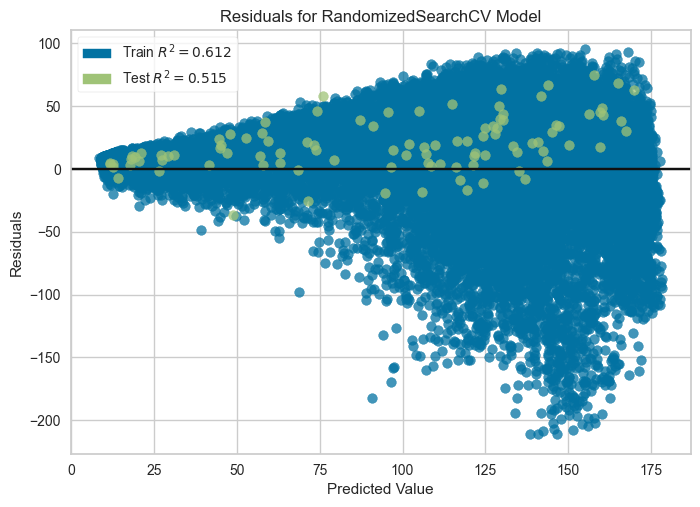

In [71]:
from yellowbrick.regressor import residuals_plot
viz = residuals_plot(rf_random, x_train_prepared, y_train, x_test_prepared, y_test, hist=False)

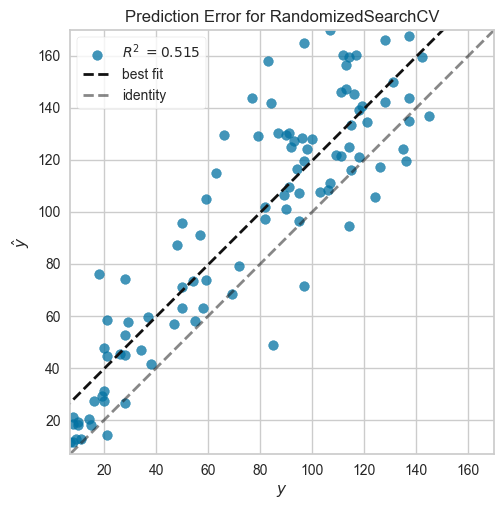

In [72]:
visualizer = prediction_error(rf_random, x_train_prepared, y_train, x_test_prepared, y_test)

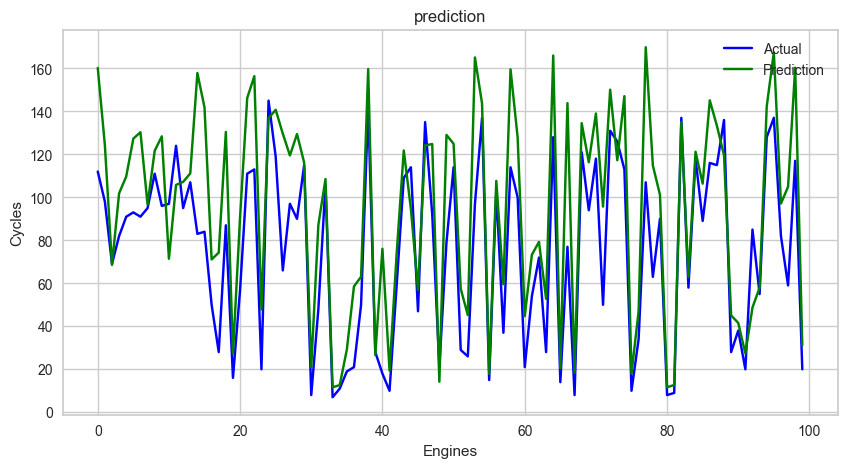

In [73]:
fig = plt.figure(figsize=(10, 5))
plt.plot(y_test, color="blue")
plt.plot(rf_random_test_predictions, color="green")
plt.title('prediction')
plt.ylabel('Cycles')
plt.xlabel('Engines')
plt.legend(['Actual', 'Prediction'], loc='upper right')
plt.show() 

## LGBM Regressor 

LightGBM is a gradient boosting tree-based learning algorithm which is distributed and efficient. we have tried implementing the LGBM regressor with some parameters and we could see some improved results as this is a non-linear algorithm. the RMSE score has been improved compared to the linear models. 

RepeatedKFold cross-validation scores for 3 repetitions have been taken and cross-validation scores are calculated. 

In [74]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [75]:
#LGBMRegressor
from lightgbm import LGBMRegressor
model_lgbm = LGBMRegressor(max_depth=7, num_leaves = 2)
# fit the model on the whole dataset
model_lgbm.fit(x_train_prepared, y_train)
model_lgbm_train_predictions = model_lgbm.predict(x_train_prepared)
model_lgbm_test_predictions = model_lgbm.predict(x_test_prepared)

print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, model_lgbm_test_predictions)**0.5))
print('Mean Absolute Error:', (metrics.mean_absolute_error(y_test, model_lgbm_test_predictions)))

print("r2_score on Train data :", r2_score(y_train,model_lgbm_train_predictions)) 
print("r2_score on Test data :", r2_score(y_test,model_lgbm_test_predictions)) 
print(' ')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model_lgbm, x_train_prepared, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("Cross validation accuracy:", cross_val_score(model_lgbm, x_train_prepared, y_train, cv=10))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2827
[LightGBM] [Info] Number of data points in the train set: 20631, number of used features: 16
[LightGBM] [Info] Start training from score 107.807862
Root Mean Squared Error: 31.935127036621545
Mean Absolute Error: 25.14717832751449
r2_score on Train data : 0.6149852619252605
r2_score on Test data : 0.40942133740430864
 
MAE: -32.006 (0.670)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2819
[LightGBM] [Info] Number of data points in the train set: 18567, number of used features: 16
[LightGBM] [Info] Start training from score 107.223838
[LightGBM] [Info] Auto-choosing col-wise multi-threadi

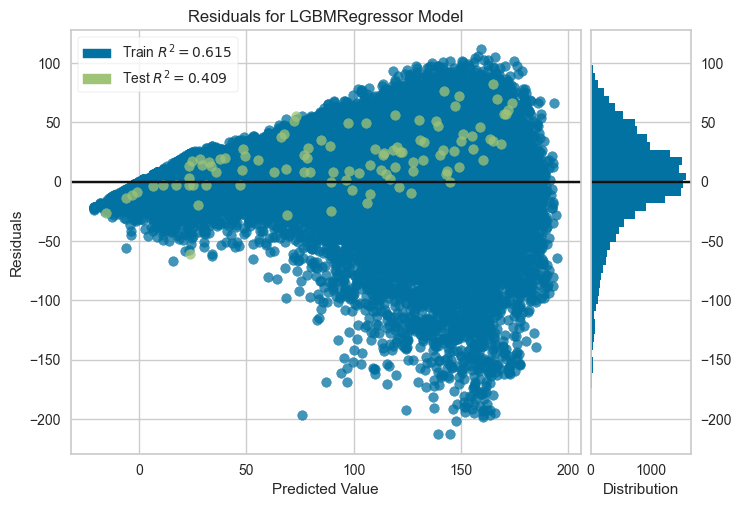

<Axes: title={'center': 'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [76]:
from yellowbrick.regressor import ResidualsPlot

# Initialize the visualizer
visualizer = ResidualsPlot(model_lgbm)

# Fit the training data to the visualizer
visualizer.fit(x_train_prepared, y_train)

# Evaluate the model on the test data
visualizer.score(x_test_prepared, y_test)

# Draw the residuals plot
visualizer.show()


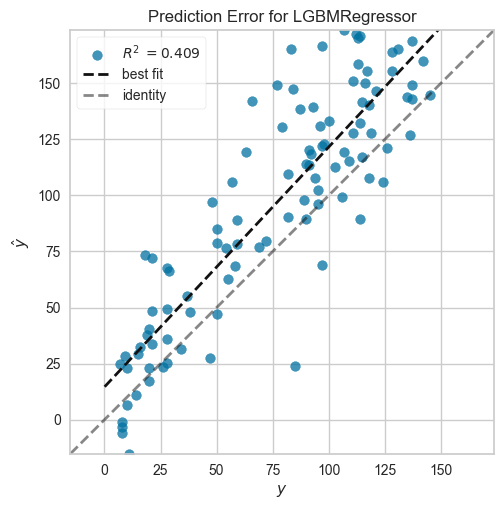

In [77]:
visualizer = prediction_error(model_lgbm, x_train_prepared, y_train, x_test_prepared, y_test)

## Actual vs predicted output values for the LGBMRegressor model.

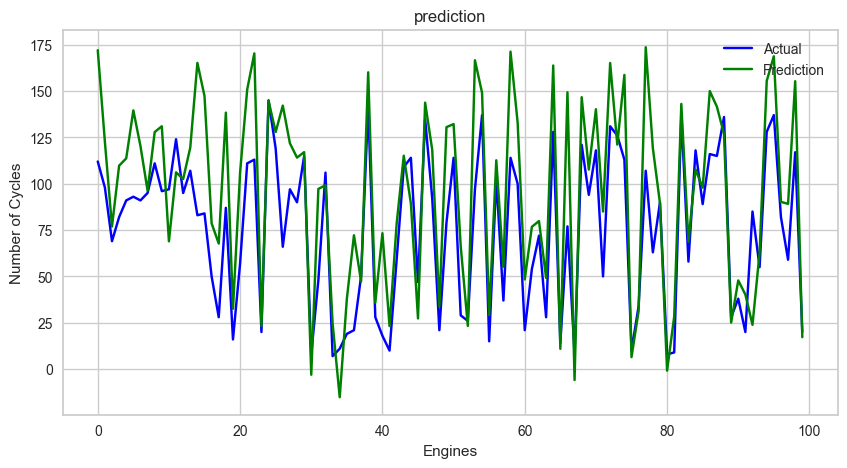

In [78]:
fig = plt.figure(figsize=(10, 5))
plt.plot(y_test, color="blue")
plt.plot(model_lgbm_test_predictions, color="green")
plt.title('prediction')
plt.ylabel('Number of Cycles')
plt.xlabel('Engines')
plt.legend(['Actual', 'Prediction'], loc='upper right')
plt.show() 

## XGBRegressor 

XGBoost is an optimized distributed gradient boosting algorithm which is highly efficient and flexible. which performs in parallel tree-based learning. the model is trained with parameters and the model seems to be performed a bit slightly less than other non-linear models.

In [79]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor(learning_rate =0.1, n_estimators=100, max_depth=7, min_child_weight=1, gamma=0, subsample=0.8, 
                                                                                         colsample_bytree=0.8, seed=27)
model_xgb.fit(x_train_prepared, y_train)
model_xgb_train_predictions = model_xgb.predict(x_train_prepared)
model_xgb_test_predictions = model_xgb.predict(x_test_prepared)

print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, model_xgb_test_predictions)**0.5))
print('Mean Absolute Error:', (metrics.mean_absolute_error(y_test, model_xgb_test_predictions)))

print("r2_score on Train data :", r2_score(y_train,model_xgb_train_predictions)) 
print("r2_score on Test data :", r2_score(y_test,model_xgb_test_predictions)) 
print("Cross validation accuracy:", cross_val_score(model_xgb, x_train_prepared, y_train, cv=10))

Root Mean Squared Error: 33.70046030319794
Mean Absolute Error: 24.172568850517273
r2_score on Train data : 0.7747531880647799
r2_score on Test data : 0.3423238068193334
Cross validation accuracy: [0.72444003 0.69780963 0.54987811 0.71180051 0.73245019 0.52450482
 0.39289553 0.67349722 0.56018092 0.56428229]


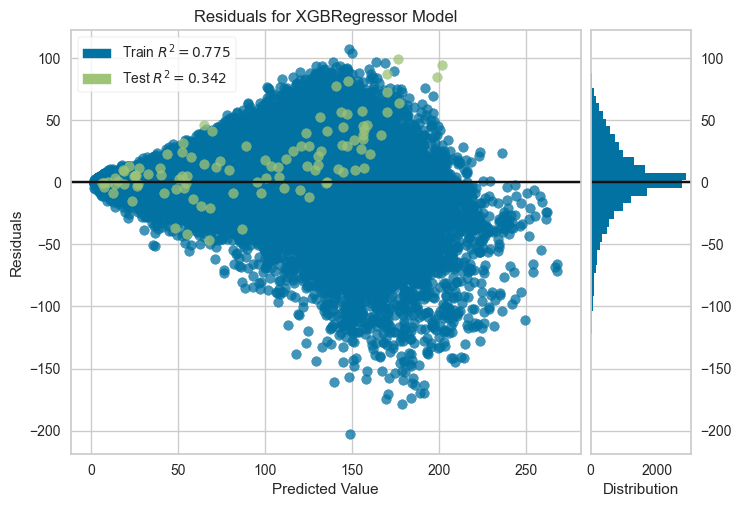

<Axes: title={'center': 'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [80]:
from yellowbrick.regressor import ResidualsPlot
from xgboost import XGBRegressor

# Assuming you've trained an XGBoost model named model_xgb
# Initialize the visualizer
visualizer = ResidualsPlot(model_xgb)
# Fit the training data to the visualizer
visualizer.fit(x_train_prepared, y_train)
# Evaluate the model on the test data
visualizer.score(x_test_prepared, y_test)
# Draw the residuals plot
visualizer.show()


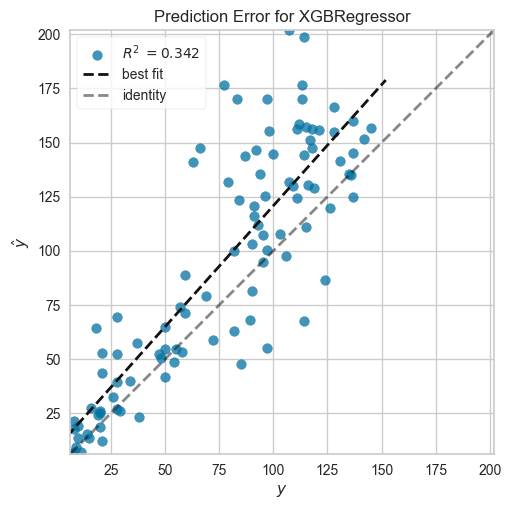

In [81]:
visualizer = prediction_error(model_xgb, x_train_prepared, y_train, x_test_prepared, y_test)

## Actual vs predicted output values for the XGBRegressor model.

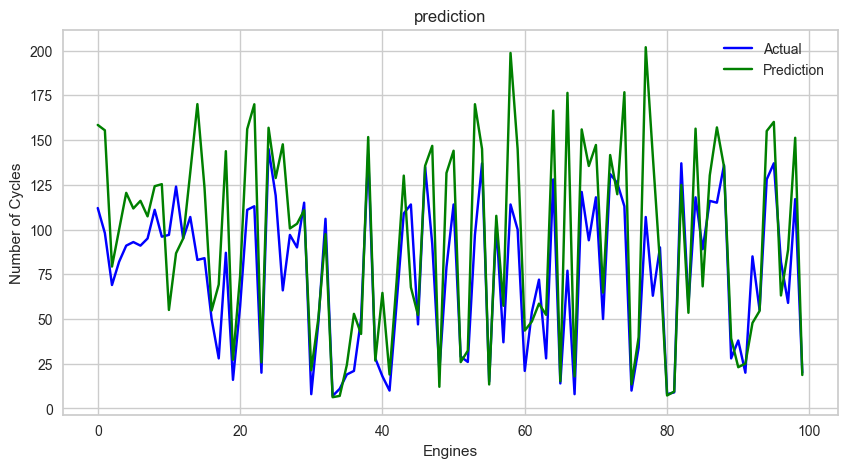

In [82]:
fig = plt.figure(figsize=(10, 5))
plt.plot(y_test, color="blue")
plt.plot(model_xgb_test_predictions, color="green")
plt.title('prediction')
plt.ylabel('Number of Cycles')
plt.xlabel('Engines')
plt.legend(['Actual', 'Prediction'], loc='upper right')
plt.show() 

## CatBoostRegressor 

CatBoost is a machine learning algorithm that uses gradient boosting on tree-based learning. The model performed well comparatively with a good test score(0.4343). 

In [83]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [84]:
from catboost import CatBoostRegressor
model_cat = CatBoostRegressor(verbose=0, n_estimators=100, max_depth=7,learning_rate =0.1)
model_cat.fit(x_train_prepared, y_train)
model_cat_train_predictions = model_cat.predict(x_train_prepared)
model_cat_test_predictions = model_cat.predict(x_test_prepared)

print('Root Mean Squared Error:', (metrics.mean_squared_error(y_test, model_cat_test_predictions)**0.5))
print('Mean Absolute Error:', (metrics.mean_absolute_error(y_test, model_cat_test_predictions)))

print("r2_score on Train data :", r2_score(y_train,model_cat_train_predictions)) 
print("r2_score on Test data :", r2_score(y_test,model_cat_test_predictions)) 
print("Cross validation accuracy:", cross_val_score(model_cat, x_train_prepared, y_train, cv=10))

Root Mean Squared Error: 31.25340902017025
Mean Absolute Error: 22.8227389118037
r2_score on Train data : 0.6679950488043246
r2_score on Test data : 0.43436633815196046
Cross validation accuracy: [0.72878315 0.71272761 0.55860583 0.7220684  0.7531919  0.53876503
 0.39445081 0.67997691 0.56439028 0.57389073]


## Actual vs predicted output values for the CatBoostRegressor model.

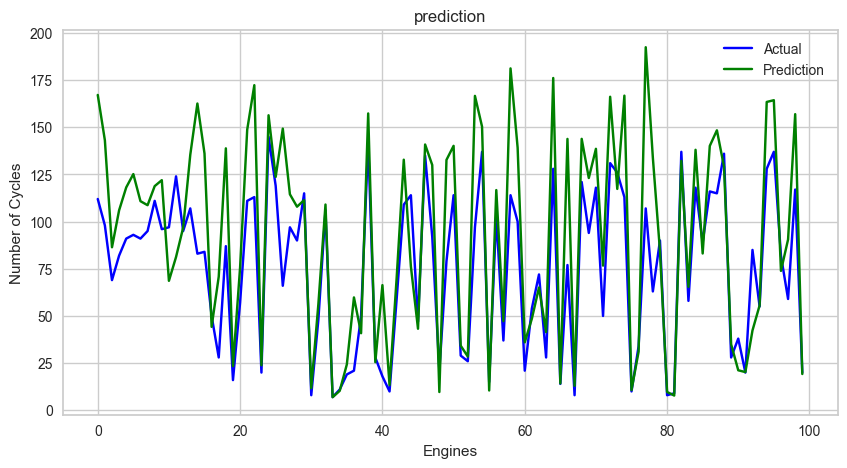

In [85]:
fig = plt.figure(figsize=(10, 5))
plt.plot(y_test, color="blue")
plt.plot(model_cat_test_predictions, color="green")
plt.title('prediction')
plt.ylabel('Number of Cycles')
plt.xlabel('Engines')
plt.legend(['Actual', 'Prediction'], loc='upper right')
plt.show() 

## Results Comparision

As discussed in the problem statement it is a Regression problem. Here, we have to find the remaining useful life of an engine based on the generated sensor data for different operational conditions. 

From the Exploratory Data Analysis, we can infer that we have enough attributes for predicting the target variable (RUL) of an engine. we have done various visualizations describing the relationship between variables. 

Based on the known variables feature selection has been done and selected features are used in implementing the model. 

Algorithms implemented for finding the RUL prediction.

1. Linear Regression
2. Decision tree Regression
3. Polynomial Regression
4. Lasso Regression 
5. RandomForest Regression 
6. LGBM Regression
7. XGBoost Regression
8. CatBoost Regressor 

Among the models, we have linear models and non-linear models. The data is non-linear with the target variable. As per the results, non-linear models performed better than linear models.
Best parameters for Random Forest Regression is {'n_estimators': 75,
 'min_samples_split': 2,
 'max_features': 2,
 'max_depth': 5,
 'bootstrap': True} 
RANDOM FOREST REGRESSION outperformed all the other models with an r2_score of 0.5154 and with an RMSE of ±28.96


|  Model                  | r2_score (Train) | r2-score (Test)  | RMSE      | MAE          | 
|-------------------------|------------------|------------------|-----------|--------------|
| Linear Regression       | 0.5794           | 0.4054           |  32.04    | 25.59        |
| Polynomial Regression   | 0.6269           | 0.4332           |  31.28    | 23.84        |
| Decisiontree Regression | 0.6076           | 0.4502           |  30.84    | 23.6         |
| Lasso Regression        | 0.5794           | 0.4054           |  32.04    | 25.59        |
| Randomforest Regression | 0.6117           | 0.5154           |  28.96    | 23.66        | 
| LGBM Regression         | 0.6146           | 0.4135           |  31.82    | 25.11        |
| XGBRegression           | 0.7756           | 0.3685           |  33.02    | 24.09        |
| CatBoostRegresson       | 0.6679           | 0.4343           |  31.25    | 22.82        |




## using binary classification

In [86]:
df_train=train_df
df_test=df_test_data
 # Define the period for binary classification

period = 40

    # Create binary labels based on time-to-failure
df_train['b_label'] = df_train['RUL'].apply(lambda x: 1 if x <= period else 0)
df_test['b_label'] = df_test['RUL'].apply(lambda x: 1 if x <= period else 0)


In [87]:
df_train

id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0        1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70   
1        1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82   
2        1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99   
3        1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79   
4        1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85   
...    ...    ...       ...       ...       ...     ...     ...      ...   
20626  100    196   -0.0004   -0.0003     100.0  518.67  643.49  1597.98   
20627  100    197   -0.0016   -0.0005     100.0  518.67  643.54  1604.50   
20628  100    198    0.0004    0.0000     100.0  518.67  643.42  1602.46   
20629  100    199   -0.0011    0.0003     100.0  518.67  643.23  1605.26   
20630  100    200   -0.0032   -0.0005     100.0  518.67  643.85  1600.38   

            s4     s5  ...      s14     s15   s16  s17   s18    s19    s20  \
0      1400.60  14.62  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1      1403.14  14.62  ...  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2      1404.20  14.62  ...  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3      1401.87  14.62  ...  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4      1406.22  14.62  ...  8133.80  8.4294  0.03  393  2388  100.0  38.90   
...        ...    ...  ...      ...     ...   ...  ...   ...    ...    ...   
20626  1428.63  14.62  ...  8137.60  8.4956  0.03  397  2388  100.0  38.49   
20627  1433.58  14.62  ...  8136.50  8.5139  0.03  395  2388  100.0  38.30   
20628  1428.18  14.62  ...  8141.05  8.5646  0.03  398  2388  100.0  38.44   
20629  1426.53  14.62  ...  8139.29  8.5389  0.03  395  2388  100.0  38.29   
20630  1432.14  14.62  ...  8137.33  8.5036  0.03  396  2388  100.0  38.37   

           s21  RUL  b_label  
0      23.4190  191        0  
1      23.4236  190        0  
2      23.3442  189        0  
3      23.3739  188        0  
4      23.4044  187        0  
...        ...  ...      ...  
20626  22.9735    4        1  
20627  23.1594    3        1  
20628  22.9333    2        1  
20629  23.0640    1        1  
20630  23.0522    0        1  

[20631 rows x 28 columns]

In [88]:
df_test

id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0     1     31   -0.0006    0.0004     100.0  518.67  642.58  1581.22   
1     2     49    0.0018   -0.0001     100.0  518.67  642.55  1586.59   
2     3    126   -0.0016    0.0004     100.0  518.67  642.88  1589.75   
3     4    106    0.0012    0.0004     100.0  518.67  642.78  1594.53   
4     5     98   -0.0013   -0.0004     100.0  518.67  642.27  1589.94   
..  ...    ...       ...       ...       ...     ...     ...      ...   
95   96     97   -0.0006    0.0003     100.0  518.67  642.30  1590.88   
96   97    134    0.0013   -0.0001     100.0  518.67  642.59  1582.96   
97   98    121    0.0017    0.0001     100.0  518.67  642.68  1599.51   
98   99     97    0.0047   -0.0000     100.0  518.67  642.00  1585.03   
99  100    198    0.0013    0.0003     100.0  518.67  642.95  1601.62   

         s4     s5  ...      s14     s15   s16  s17   s18    s19    s20  \
0   1398.91  14.62  ...  8130.11  8.4024  0.03  393  2388  100.0  38.81   
1   1410.83  14.62  ...  8126.90  8.4505  0.03  391  2388  100.0  38.81   
2   1418.89  14.62  ...  8131.46  8.4119  0.03  395  2388  100.0  38.93   
3   1406.88  14.62  ...  8133.64  8.4634  0.03  395  2388  100.0  38.58   
4   1419.36  14.62  ...  8125.74  8.4362  0.03  394  2388  100.0  38.75   
..      ...    ...  ...      ...     ...   ...  ...   ...    ...    ...   
95  1397.94  14.62  ...  8148.24  8.4110  0.03  391  2388  100.0  38.96   
96  1410.92  14.62  ...  8155.48  8.4500  0.03  395  2388  100.0  38.61   
97  1415.47  14.62  ...  8146.39  8.4235  0.03  394  2388  100.0  38.76   
98  1397.98  14.62  ...  8150.38  8.4003  0.03  391  2388  100.0  38.95   
99  1424.99  14.62  ...  8214.64  8.4903  0.03  396  2388  100.0  38.70   

        s21  RUL  b_label  
0   23.3552  112        0  
1   23.2618   98        0  
2   23.2740   69        0  
3   23.2581   82        0  
4   23.4117   91        0  
..      ...  ...      ...  
95  23.4606  137        0  
96  23.2953   82        0  
97  23.3608   59        0  
98  23.3595  117        0  
99  23.1855   20        1  

[100 rows x 28 columns]

In [89]:
df_train['b_label'].value_counts()

0    16531
1     4100
Name: b_label, dtype: int64

In [90]:
from sklearn.preprocessing import StandardScaler
X = df_train[features]
y = df_train.b_label

X1_test = df_test[features]
y1_test = df_test.b_label
scaler = StandardScaler()
scaler.fit(X)

X_scaled = pd.DataFrame(scaler.transform(X), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X1_test), columns=features)


#### RANDOMFOREST CLASSIFIER

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
# Scale the features
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X1_test), columns=features)
# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=300, max_features="sqrt", n_jobs=-1,
                                  random_state=38)
# Fit the model
rf_model.fit(X_scaled, y)
# Evaluate the model
accuracy = rf_model.score(X_test_scaled, y1_test)
print("Accuracy of test dataset:", accuracy)
print('')
# Accuracy score after hyperparameter tuning
rf_model.score(X_test_scaled, y1_test)
# Classification report
print(classification_report(y1_test, rf_model.predict(X_test_scaled)))


Accuracy of test dataset: 0.96

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.86      0.92        28

    accuracy                           0.96       100
   macro avg       0.97      0.93      0.95       100
weighted avg       0.96      0.96      0.96       100



In [92]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
acc = accuracy_score(y1_test, rf_model.predict(X_test_scaled))
precision = precision_score(y1_test, rf_model.predict(X_test_scaled))
recall = recall_score(y1_test, rf_model.predict(X_test_scaled))
f1 = f1_score(y1_test, rf_model.predict(X_test_scaled))

df_metrics = pd.DataFrame({'Accuracy': acc,
                               'Precision': precision,
                               'Recall': recall,
                               'F1_score': f1}, index=[0])
print(df_metrics)

   Accuracy  Precision    Recall  F1_score
0      0.96        1.0  0.857143  0.923077


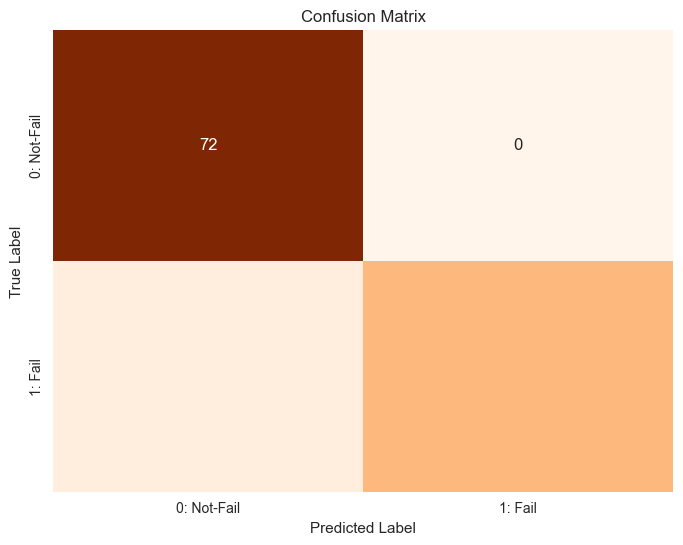

[[72  0]
 [ 4 24]]


In [93]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(y1_test, rf_model.predict(X_test_scaled))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['0: Not-Fail', '1: Fail'], yticklabels=['0: Not-Fail', '1: Fail'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(confusion_matrix)


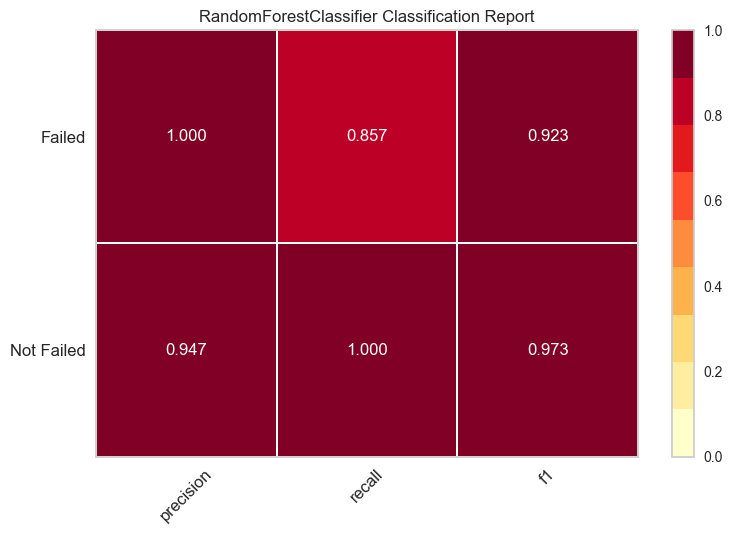

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [107]:
from yellowbrick.classifier import ClassificationReport

# Classification report visualization
visualizer = ClassificationReport(rf_model, classes=['Not Failed', 'Failed'])
visualizer.fit(X_scaled, y)
visualizer.score(X_test_scaled, y1_test)
visualizer.show()


#### DECISION TREE CLASSIFIER

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X1_test), columns=features)
decision_tree_model = DecisionTreeClassifier(max_depth=6)
decision_tree_model.fit(X_scaled, y)
accuracy = decision_tree_model.score(X_test_scaled, y1_test)
print("Accuracy of test dataset:", accuracy)
print('')
# Classification report
print(classification_report(y1_test, decision_tree_model.predict(X_test_scaled)))


Accuracy of test dataset: 0.93

              precision    recall  f1-score   support

           0       0.92      0.99      0.95        72
           1       0.96      0.79      0.86        28

    accuracy                           0.93       100
   macro avg       0.94      0.89      0.91       100
weighted avg       0.93      0.93      0.93       100



In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
y_pred_decision_tree = decision_tree_model.predict(X_test_scaled)
acc_decision_tree = accuracy_score(y1_test, y_pred_decision_tree)
precision_decision_tree = precision_score(y1_test, y_pred_decision_tree)
recall_decision_tree = recall_score(y1_test, y_pred_decision_tree)
f1_decision_tree = f1_score(y1_test, y_pred_decision_tree)
df_metrics_decision_tree = pd.DataFrame({
    'Accuracy': acc_decision_tree,
    'Precision': precision_decision_tree,
    'Recall': recall_decision_tree,
    'F1_score': f1_decision_tree
}, index=[0])
print(df_metrics_decision_tree)


   Accuracy  Precision    Recall  F1_score
0      0.93   0.956522  0.785714  0.862745


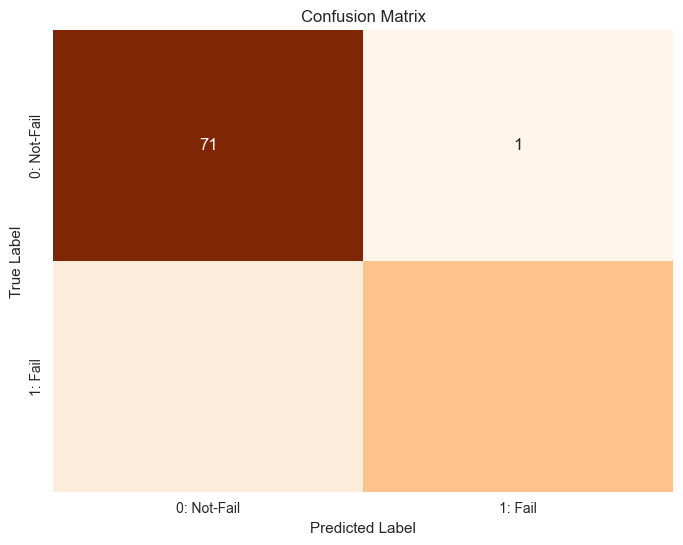

[[71  1]
 [ 6 22]]


In [96]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(y1_test, decision_tree_model.predict(X_test_scaled))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['0: Not-Fail', '1: Fail'], yticklabels=['0: Not-Fail', '1: Fail'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(confusion_matrix)


#### LOGISTIC REGRESSION

In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
scaler = StandardScaler()
scaler.fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X1_test), columns=features)
logistic_model = LogisticRegression(random_state=38)
logistic_model.fit(X_scaled, y)
accuracy = logistic_model.score(X_test_scaled, y1_test)
print("Accuracy of test dataset:", accuracy)
print('')
# Classification report
print(classification_report(y1_test, logistic_model.predict(X_test_scaled)))


Accuracy of test dataset: 0.94

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.92      0.86      0.89        28

    accuracy                           0.94       100
   macro avg       0.93      0.91      0.92       100
weighted avg       0.94      0.94      0.94       100



In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
acc = accuracy_score(y1_test, logistic_model.predict(X_test_scaled))
precision = precision_score(y1_test, logistic_model.predict(X_test_scaled))
recall = recall_score(y1_test, logistic_model.predict(X_test_scaled))
f1 = f1_score(y1_test, logistic_model.predict(X_test_scaled))

df_metrics = pd.DataFrame({'Accuracy': acc,
                               'Precision': precision,
                               'Recall': recall,
                               'F1_score': f1}, index=[0])
print(df_metrics)

   Accuracy  Precision    Recall  F1_score
0      0.94   0.923077  0.857143  0.888889


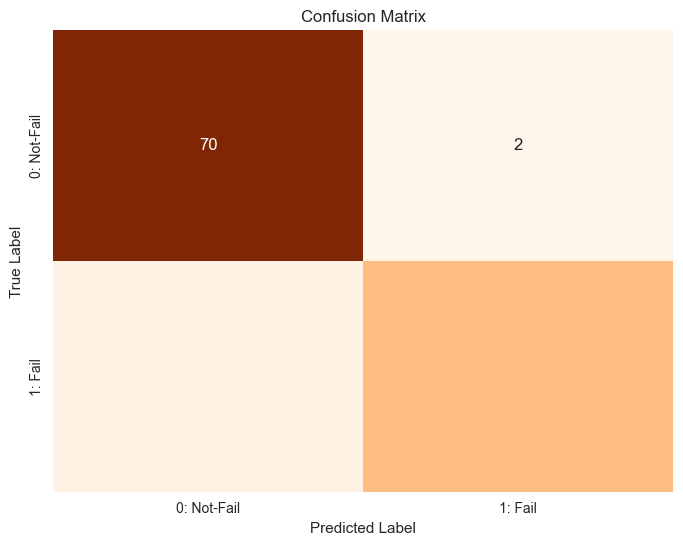

[[70  2]
 [ 4 24]]


In [99]:
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(y1_test, logistic_model.predict(X_test_scaled))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['0: Not-Fail', '1: Fail'], yticklabels=['0: Not-Fail', '1: Fail'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
print(confusion_matrix)